Example adapted from https://www.geeksforgeeks.org/deep-learning/non-dominated-sorting-genetic-algorithm-2-nsga-ii/

In [ ]:
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

In [ ]:
# Parameters

round_digits = 5
pop_size = 100
max_gen = 100
k_intensity = 0.9
l_intensity = 0.9

# Initialization
min_x = 0
max_x = 2000
min_y = 0
max_y = 1000
scale_dev = 3

In [ ]:
# First function to optimize

def function1(l, k):
    k_final = min(k, max_y)
    l_final = min(l, max_x)
    return round(0.5 * (k_final ** k_intensity) * (l_final ** (1 - k_intensity)), 2)  # capital intensivo

# Second function to optimize
def function2(l, k):
    k_final = max(max_y - k, 0)
    l_final = max(max_x - l, 0)
    return round(0.5 * (k_final ** (1 - l_intensity)) * (l_final ** l_intensity), 2) # trabajo intensivo

In [ ]:
# Function to carry out NSGA-II's fast non dominated sort
# El dominio son los valores de la función, son 2 funciones. Las funciones pueden tener más de una variable

def fast_non_dominated_sort(values1, values2):
    S = [[] for _ in range(len(values1))]
    front = [[]]
    n = [0 for _ in range(len(values1))]
    rank = [0 for _ in range(len(values1))]

    for p in range(len(values1)):
        S[p] = []
        n[p] = 0
        for q in range(len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or \
               (values1[p] >= values1[q] and values2[p] > values2[q]) or \
               (values1[p] > values1[q] and values2[p] >= values2[q]):
                S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or \
                 (values1[q] >= values1[p] and values2[q] > values2[p]) or \
                 (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    if q not in Q:
                        Q.append(q)
        i += 1
        front.append(Q)
    del front[-1]
    return front

Test the sorting function

In [ ]:
fast_non_dominated_sort([0, 1, 2, 4], [1, 0, 1, 3]) # [f1(l, k), f2(l, k)], [f1(l, k), f2(l, k)]
# Devuelve indices

[[3], [2], [0, 1]]

In [ ]:
# Function to calculate crowding distance
# It receives the values for ALL the points, and the indexes of a specific front
# Edge cases: 3 points equal

def crowding_distance(values1, values2, front):
  l = len(front)
  distance = [0 for i in range(l)]
  values1_filtered = [values1[i] for i in front]
  values2_filtered = [values2[i] for i in front]
  values = [values1_filtered, values2_filtered]
  for m in range(2):
    I = [(x, f) for x, f in sorted(zip(values[m], front))]
    distance[0] = float('inf')
    distance[l-1] = float('inf')
    f_max = max(values[m])
    f_min = min(values[m])
    for i in range(1, l-1):
      if f_max == 0 and f_min == 0:
        distance[i] = float('inf')
      distance[i] += (I[i+1][0] - I[i-1][0])/(f_max - f_min)
    ordered_vals = [x for x in zip(*I)][1]
    I = [(round(d, round_digits), v) for d, v in zip(distance, ordered_vals)]
  return I

Test the crowding distance function

In [ ]:
crowding_distance([0, 1, 2, 4], [0, 2, 1, 3], [0, 1, 2, 3])

# f1max = 4, f1min = 0
# f2max = 3, f2min = 0
# Sort on f1 - [0, 1, 2, 4] -> order intact
# i = 0 -> inf
# i = 1 -> 2/4 -> i_ori = 1
# i = 2 -> 3/4 -> i_ori = 2
# i = 3 -> inf -> -> i_ori = 3
# Sort on f2 - [0, 1, 2, 3] -> indexes = [0, 2, 1, 3]

# i = 0 -> inf
# i = 1 -> i_ori = 2 -> 2/3
# i = 2 -> i_ori = 1 -> 2/3
# i = 3 -> i_ori = 3 -> inf

# output [inf, 2/4 + 2/3, 2/3 + 3/4, inf]

[(inf, 0), (1.16667, 2), (1.41667, 1), (inf, 3)]

In [ ]:
# Function to carry out the crossover

def crossover(x1, y1, x2, y2, scale_x = 1, scale_y = 1): # uniform crossover
    p = random.random()
    if p > 0.5:
      child_x = x1
      child_y = y2
    else:
      child_x = x2
      child_y = y1
    return mutation(child_x, 0.3, scale = scale_x), mutation(child_y, 0.3, scale = scale_y)

# Function to carry out the mutation operator. Ver el desvio estandar, el efecto sobre la diversidad

def mutation(solution, p, scale): # Favorecer pequeñas perturbaciones
    mutation_prob = random.random() # entre 0 y 1
    if mutation_prob < p: # Probabilidad de mutaciones
      flip_sign = random.random()
      noise = norm.rvs(loc = solution, scale = scale_dev * scale, size = 1, random_state=None)[0].item()
      if flip_sign > 0.5: # Con probabilidad 50% se debe aumentar o restar
        solution += noise
      else:
        solution -= noise
    return round(solution, round_digits)

# Function to assess if the individual doesnt survive

def survival(solution):
  if solution[0] > max_x or solution[0] < min_x:
    s = 0
  elif solution[1] > max_y or solution[1] < min_y:
    s = 0
  else:
    s = 1
  return s

In [ ]:
# Example

sample_solution = crossover(1, 2, 20, 30)
fit = survival(sample_solution)

print(sample_solution, fit)

(20, 2) 1


In [ ]:
# Main program starts here

# Initialization
solution_x = [round(min_x + (max_x - min_x) * random.random(), 0) for _ in range(pop_size)] # N puntos random para inicializar el algoritmo, en x
solution_y = [round(min_y + (max_y - min_y) * random.random(), 0) for _ in range(pop_size)] # N puntos random para inicializar el algoritmo, en y
std_x = stats.tstd(solution_x)
std_y = stats.tstd(solution_y)
solution = [solution_x, solution_y]
gen_no = 0

# Tracking progress for visualization
progress = []

In [ ]:
# Ejemplo de las curvas

front = 5
function1_values = [function1(solution_x[i], solution_y[i]) for i in range(pop_size)]
function2_values = [function2(solution_x[i], solution_y[i]) for i in range(pop_size)]
non_dominated_sorted_solution = fast_non_dominated_sort(function1_values[:], function2_values[:])
[print(f"""f1:{function1_values[i]}, f2:{function2_values[i]}, f1+f2:{function1_values[i]+function2_values[i]}, total_k:{solution_y[i]}, total_l:{solution_x[i]}""") for i in non_dominated_sorted_solution[front]]

f1:126.84, f2:368.9, f1+f2:495.74, total_k:715.0, total_l:90.0
f1:95.86, f2:471.1, f1+f2:566.96, total_k:34.0, total_l:1081.0
f1:115.41, f2:426.7, f1+f2:542.11, total_k:43.0, total_l:1239.0
f1:228.06, f2:340.24, f1+f2:568.3, total_k:730.0, total_l:285.0
f1:240.56, f2:304.74, f1+f2:545.3, total_k:782.0, total_l:296.0
f1:249.27, f2:207.09, f1+f2:456.36, total_k:138.0, total_l:1801.0
f1:431.7, f2:127.91, f1+f2:559.61, total_k:394.0, total_l:1892.0
f1:435.85, f2:49.68, f1+f2:485.53000000000003, total_k:383.0, total_l:1984.0


[None, None, None, None, None, None, None, None]

In [ ]:
# Ejemplo de la crowding distance

x_points = [solution_x[i] for _, i in crowding_distance(function1_values[:], function2_values[:], non_dominated_sorted_solution[front][:])]
y_points = [solution_y[i] for _, i in crowding_distance(function1_values[:], function2_values[:], non_dominated_sorted_solution[front][:])]
f1_values = [function1_values[i] for _, i in crowding_distance(function1_values[:], function2_values[:], non_dominated_sorted_solution[front][:])]
f2_values = [function2_values[i] for _, i in crowding_distance(function1_values[:], function2_values[:], non_dominated_sorted_solution[front][:])]
distance_values = [d for d, _ in crowding_distance(function1_values[:], function2_values[:], non_dominated_sorted_solution[front][:])]


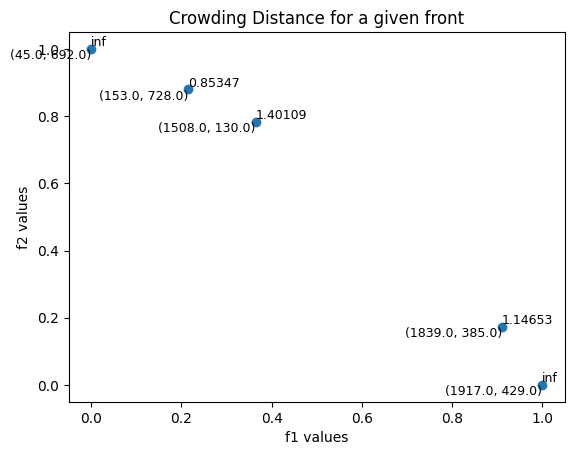

In [ ]:
# Grafico con la curva de pareto y la crowding distance

plt.xlabel("f1 values")
plt.ylabel("f2 values")
plt.title("Crowding Distance for a given front")
range_f1 = max(f1_values) - min(f1_values)
range_f2 = max(f2_values) - min(f2_values)

f1_values = [(f- min(f1_values))/range_f1 for f in f1_values]
f2_values = [(f- min(f2_values))/range_f2 for f in f2_values]

for f1, f2, x, y, di in zip(f1_values, f2_values, x_points, y_points, distance_values):
    plt.text(f1, f2, di, fontsize=9, ha="left", va="bottom")
    plt.text(f1, f2, (round(x, 2), round(y, 2)), fontsize=9, ha="right", va="top")

plt.scatter(f1_values, f2_values)

plt.show()

In [ ]:
while gen_no < max_gen:
    function1_values = [function1(solution_x[i], solution_y[i]) for i in range(pop_size)]
    function2_values = [function2(solution_x[i], solution_y[i]) for i in range(pop_size)]
    non_dominated_sorted_solution = fast_non_dominated_sort(function1_values[:], function2_values[:])
    print(f"The best front for Generation number {gen_no} is")
    for value in non_dominated_sorted_solution[0]:
        best_x_points = round(solution_x[value], round_digits)
        best_y_points = round(solution_y[value], round_digits)
        print(f"""k:{best_x_points}, l:{best_y_points}""", end="\n")
    print("\n")

    # Store progress for visualization
    progress.append((function1_values, function2_values))

    crowding_distance_values = []
    for i in range(len(non_dominated_sorted_solution)):
        crowding_distance_values.append(crowding_distance(function1_values[:], function2_values[:], non_dominated_sorted_solution[i][:]))
    solution2 = [solution[0][:], solution[1][:]]
    # Generating offsprings
    while len(solution2[0]) != 2 * pop_size: # Hasta completar una nueva generación de individuos
        a1 = random.randint(0, pop_size - 1) # Sampleo un padre
        b1 = random.randint(0, pop_size - 1) # Sampleo otro padre
        x, y = crossover(solution[0][a1], solution[1][a1], solution[0][b1], solution[1][b1], std_x, std_y)
        s = survival((x, y))
        if s == 1:
          solution2[0].append(x)
          solution2[1].append(y)

    function1_values2 = [function1(solution2[0][i], solution2[1][i]) for i in range(2 * pop_size)]
    function2_values2 = [function2(solution2[0][i], solution2[1][i]) for i in range(2 * pop_size)]
    non_dominated_sorted_solution2 = fast_non_dominated_sort(function1_values2[:], function2_values2[:])
    crowding_distance_values2 = []
    for i in range(len(non_dominated_sorted_solution2)):

        crowding_distance_values2.append(crowding_distance(function1_values2[:], function2_values2[:], non_dominated_sorted_solution2[i][:]))

    new_solution = [[],[]]
    # Ordenar cada frontera segun la crowding distance
    # Traer N ejemplos
    for i in range(len(non_dominated_sorted_solution2)):
        d, index = zip(*crowding_distance_values2[i])
        sorted_distances = [(x, f) for x, f in sorted(zip(d, index), reverse = True)]
        for _, j in sorted_distances:
            ind_x = solution2[0][j]
            ind_y = solution2[1][j]
            new_solution[0].append(ind_x)
            new_solution[1].append(ind_y)
            if len(new_solution[0]) == pop_size:
                break
        if len(new_solution[0]) == pop_size:
            break
    solution_x = new_solution[0]
    solution_y = new_solution[1]
    std_x = stats.tstd(solution_x)
    std_y = stats.tstd(solution_y)
    solution = [solution_x, solution_y]
    gen_no += 1

Streaming output truncated to the last 5000 lines.
k:120.0, l:766.86643
k:422.0, l:956.0
k:1004.74874, l:956.0
k:200.37773, l:843.0
k:422.0, l:977.96386
k:1997.84954, l:998.0
k:1968.91483, l:998.0
k:62.27584, l:376.42679
k:120.0, l:910.60135
k:156.0, l:843.0
k:1845.99798, l:998.0
k:683.13605, l:977.96386
k:1997.84954, l:998.0
k:968.288, l:989.0
k:1997.84954, l:998.0
k:350.0, l:977.96386
k:1198.7908, l:977.96386
k:1240.18699, l:989.0
k:879.90852, l:989.0
k:1290.28528, l:989.0
k:1267.89183, l:989.0
k:1139.02807, l:989.0
k:1671.27057, l:998.0
k:350.0, l:963.32099
k:1340.42098, l:998.0
k:1726.1967, l:998.0
k:62.27584, l:784.43616
k:185.37832, l:790.0
k:1240.18699, l:998.0
k:382.66992, l:977.96386
k:1323.87858, l:998.0
k:652.5284, l:983.0
k:292.25577, l:914.0
k:79.32994, l:745.79986
k:62.27584, l:338.21275
k:62.27584, l:720.0
k:1004.74874, l:989.0
k:683.13605, l:956.0
k:5.0, l:242.46855
k:1997.84954, l:998.0
k:350.0, l:914.0
k:1530.40612, l:998.0
k:1997.84954, l:998.0
k:1976.69111, l:998.0


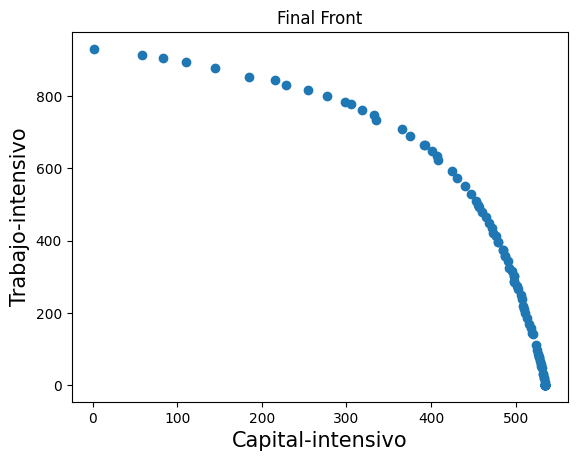

In [ ]:
# Let's plot the final front
function1_values = [function1(solution_x[i], solution_y[i]) for i in range(pop_size)]
function2_values = [function2(solution_x[i], solution_y[i]) for i in range(pop_size)]

# Visualize the final front
plt.xlabel('Capital-intensivo', fontsize=15)
plt.ylabel('Trabajo-intensivo', fontsize=15)
plt.title('Final Front')
plt.scatter(function1_values, function2_values)
plt.show()

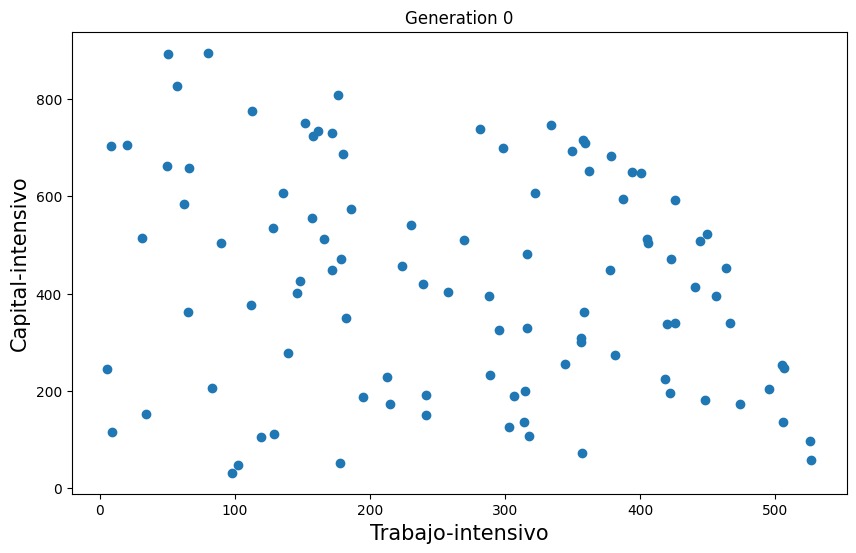

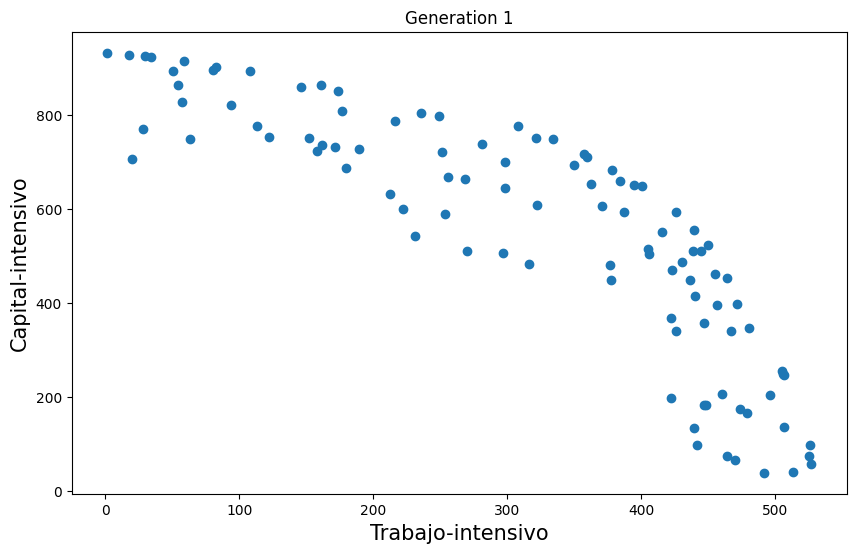

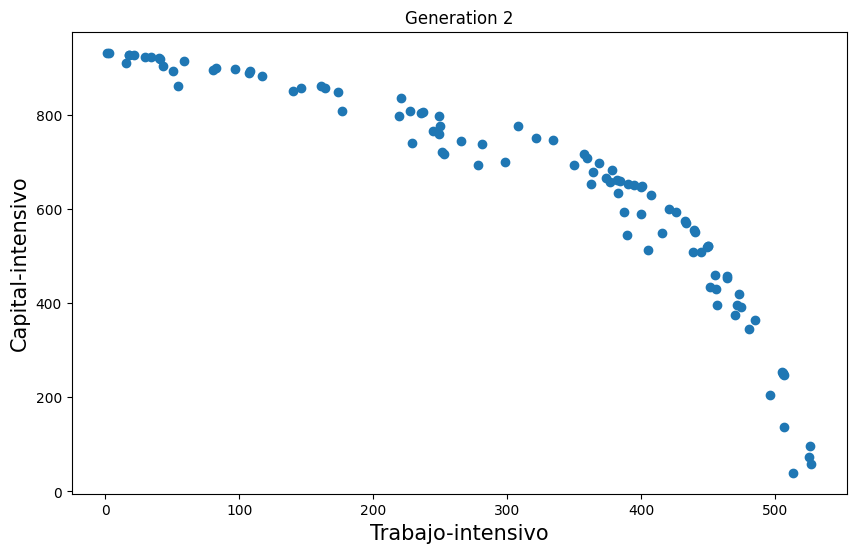

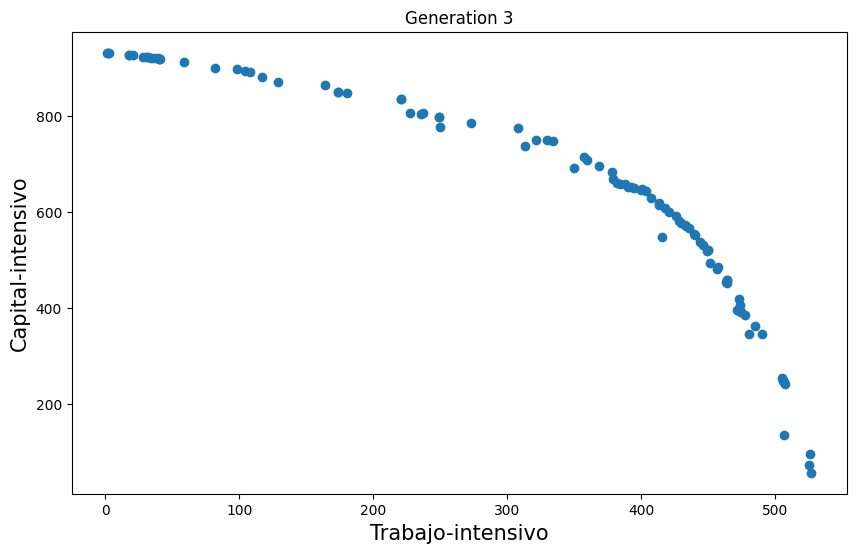

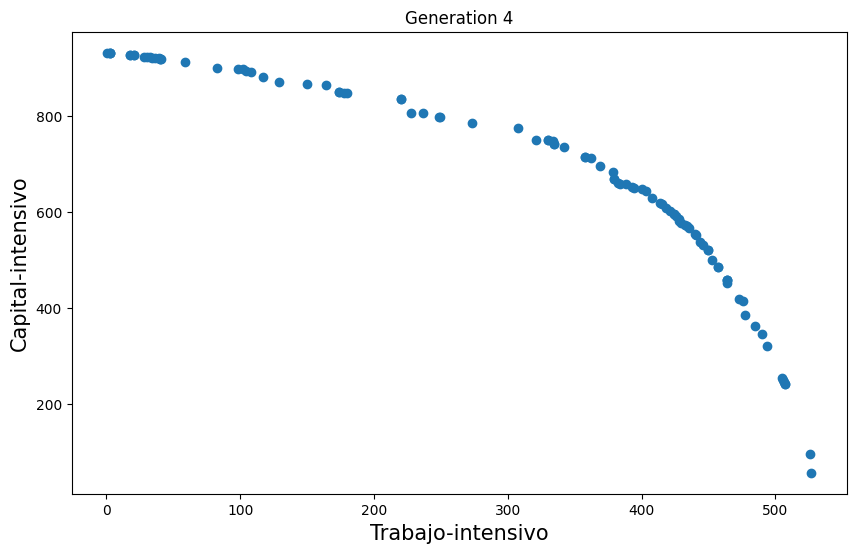

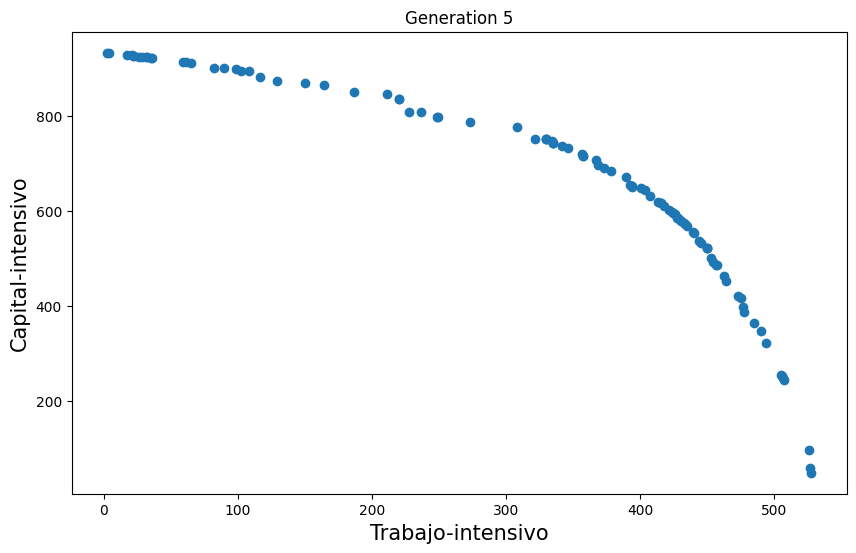

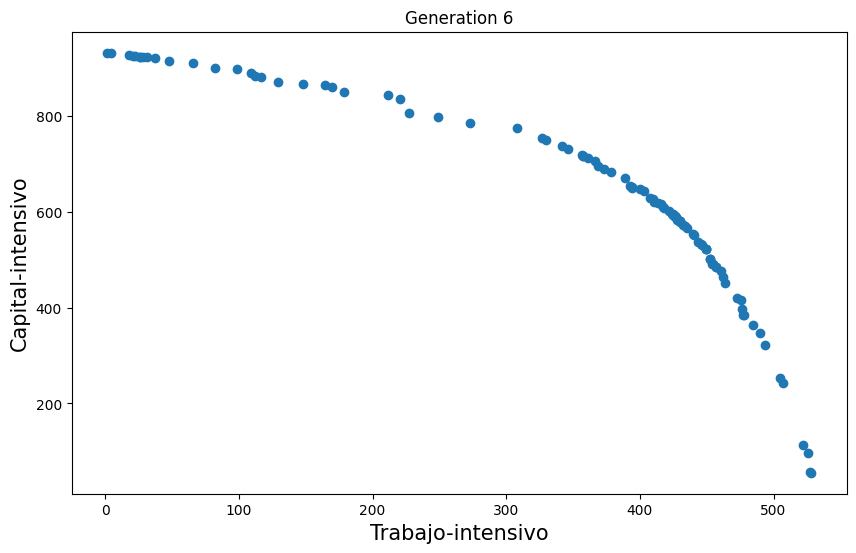

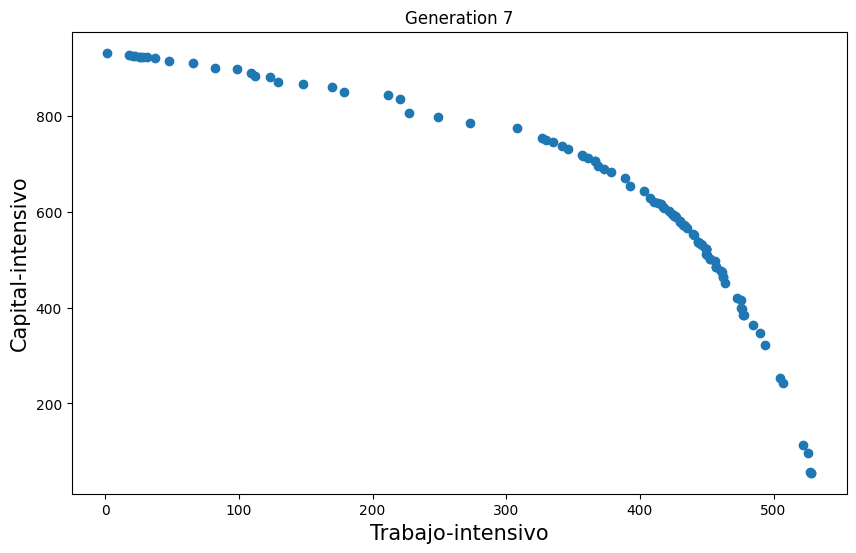

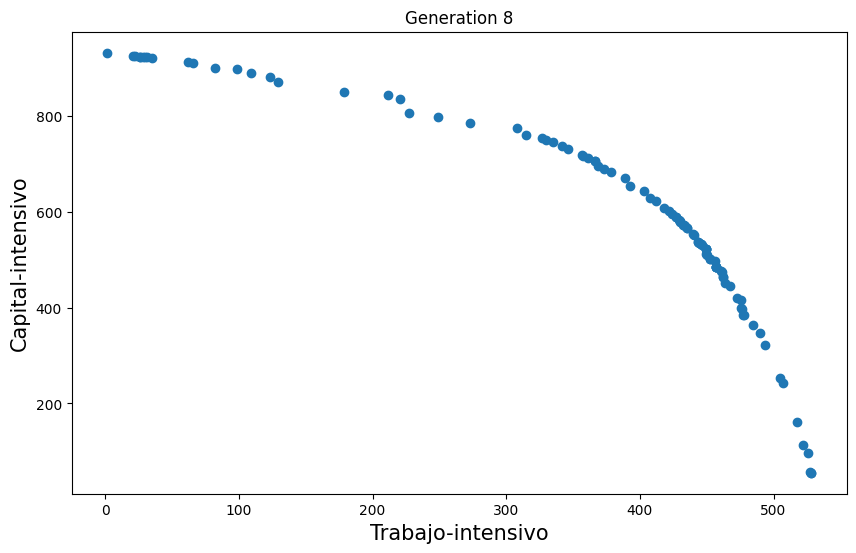

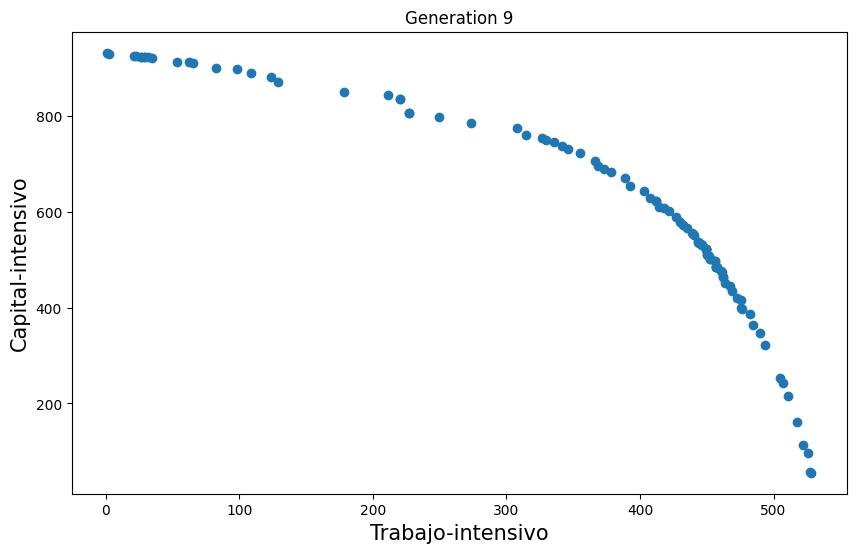

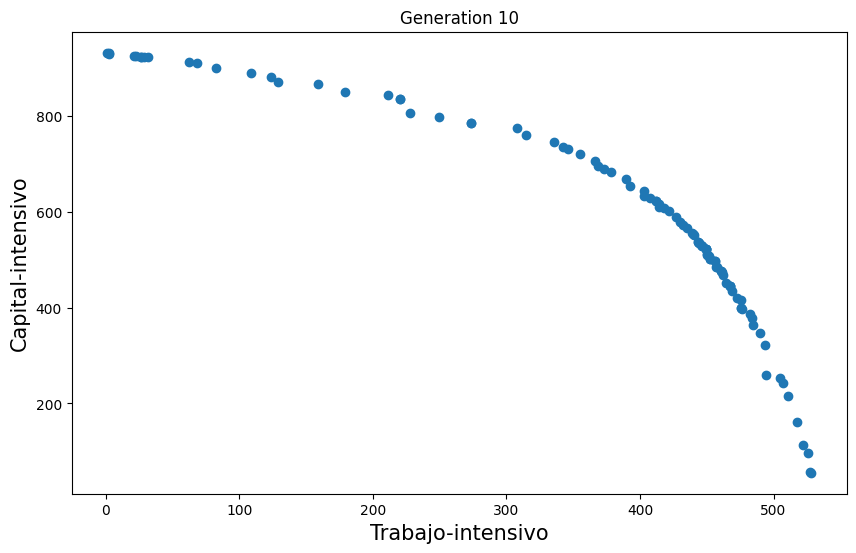

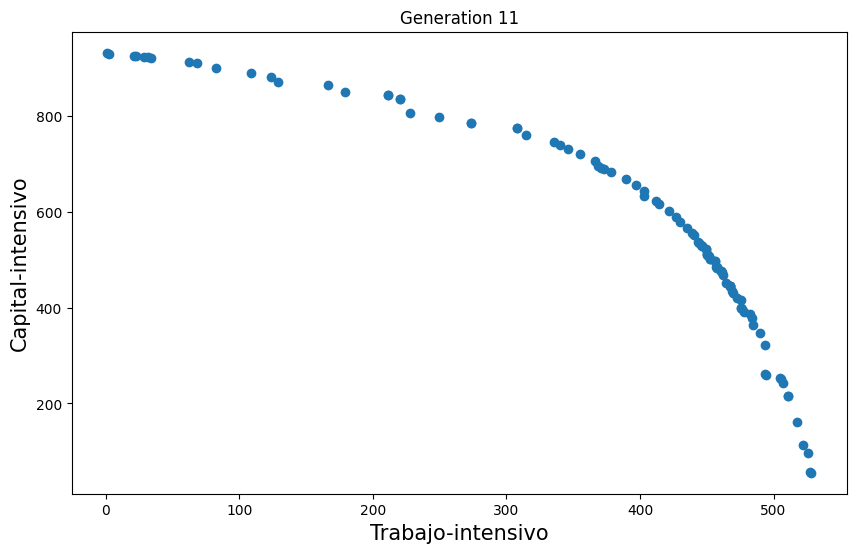

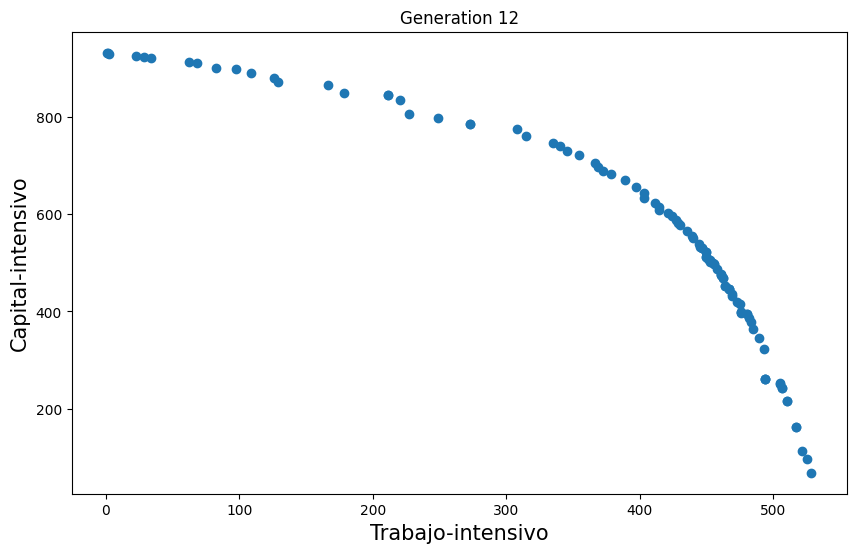

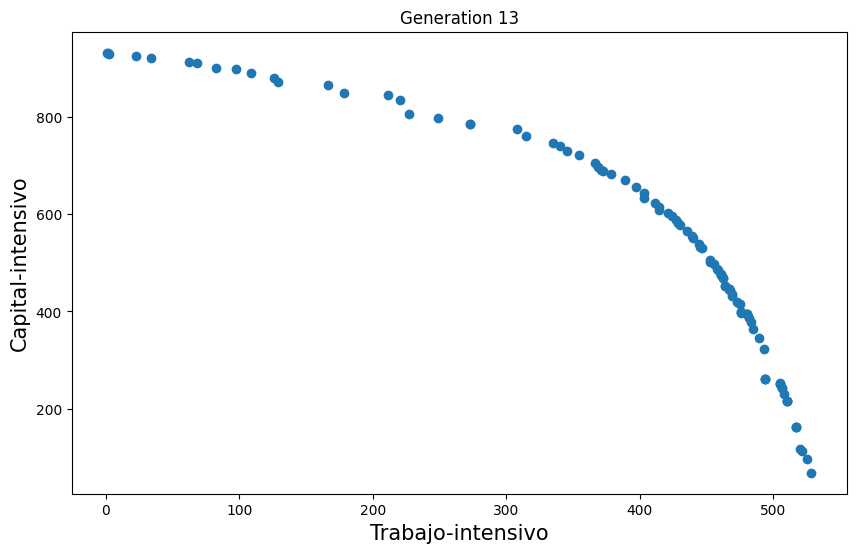

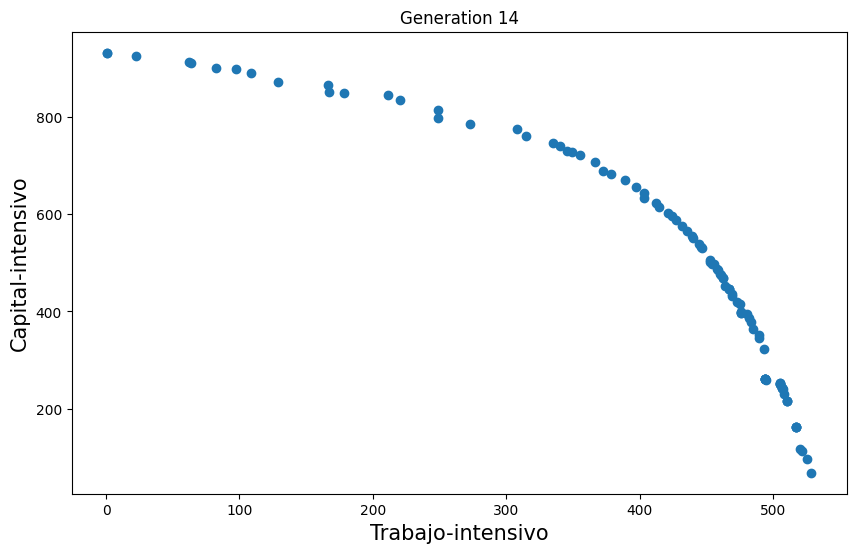

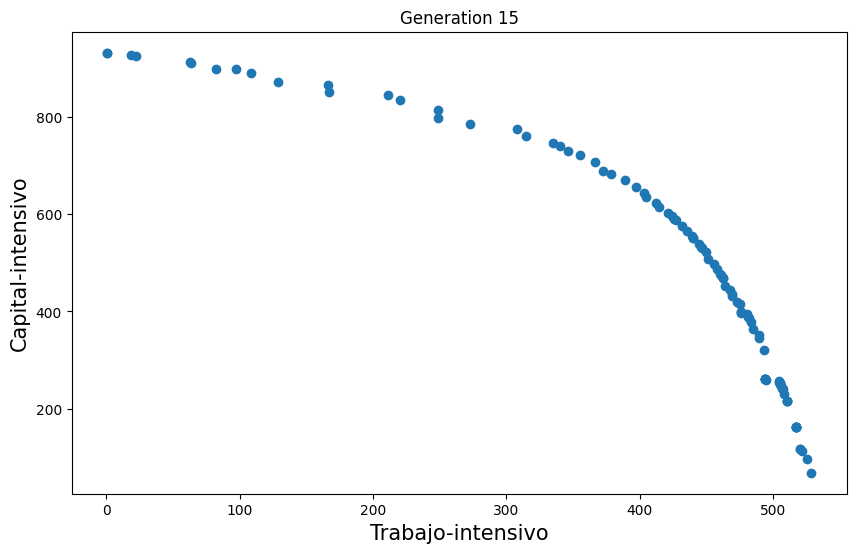

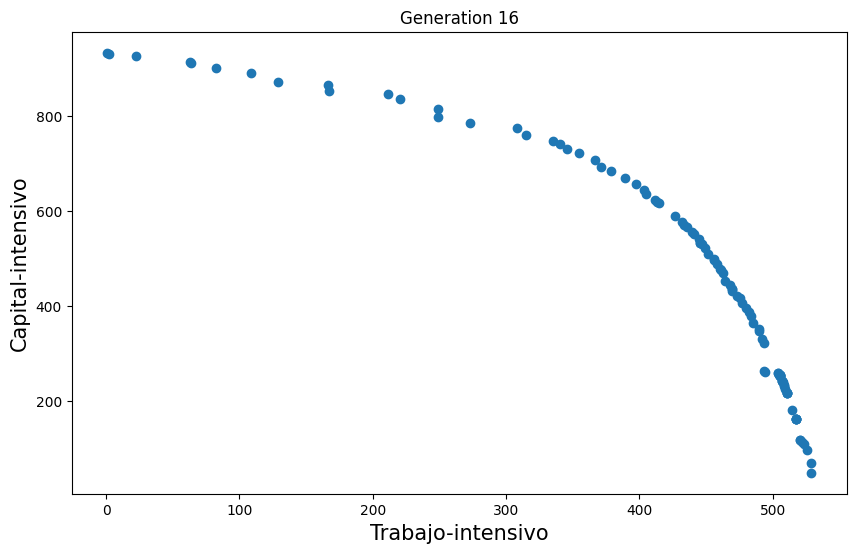

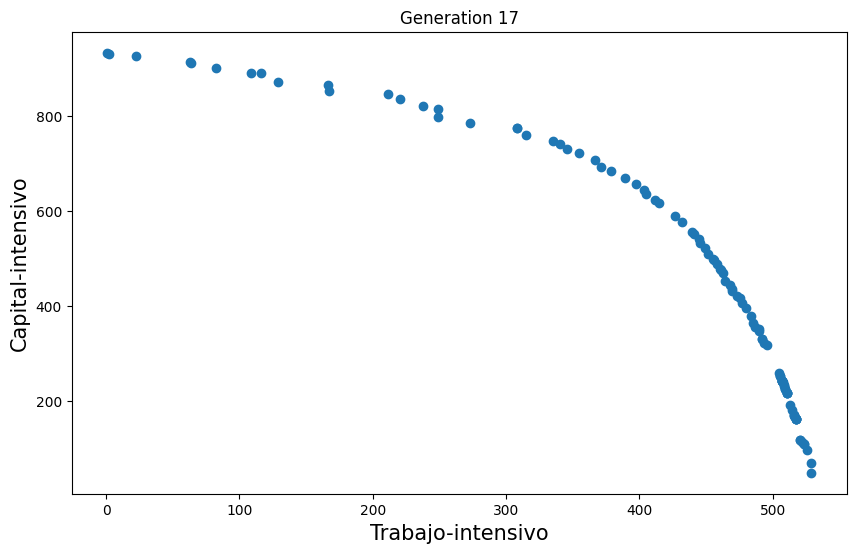

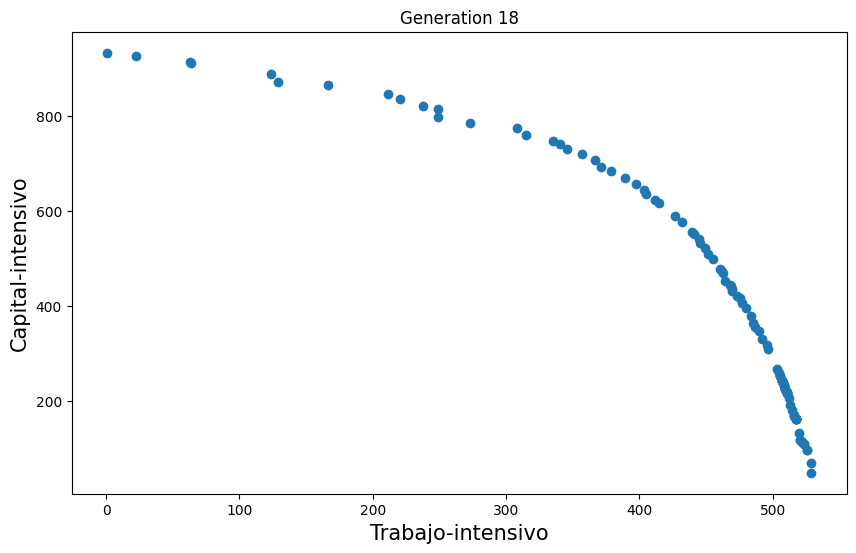

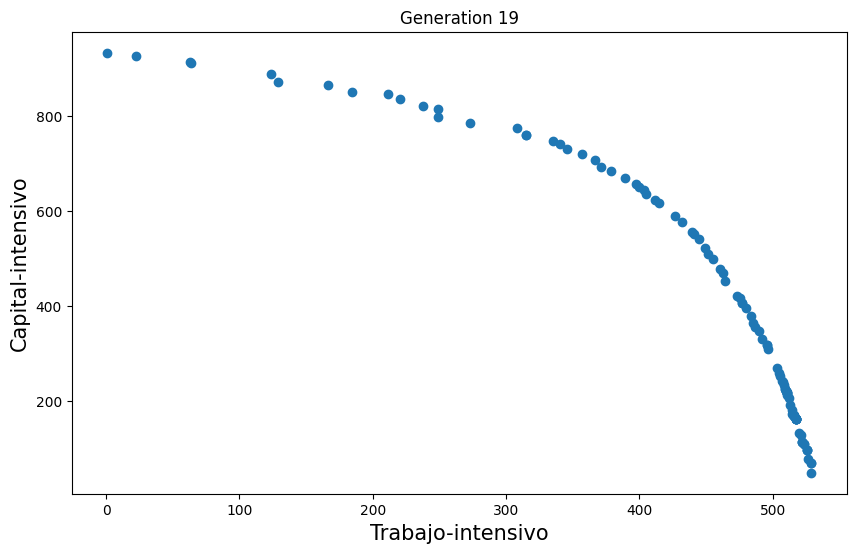

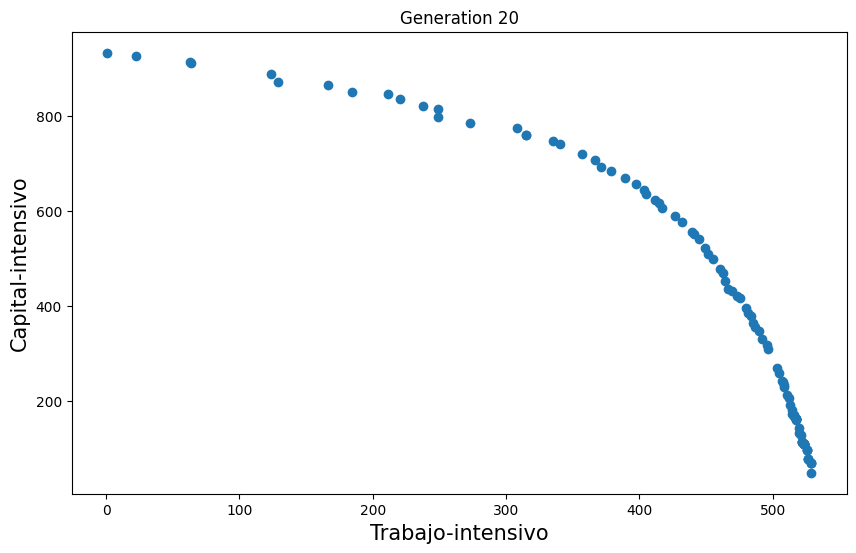

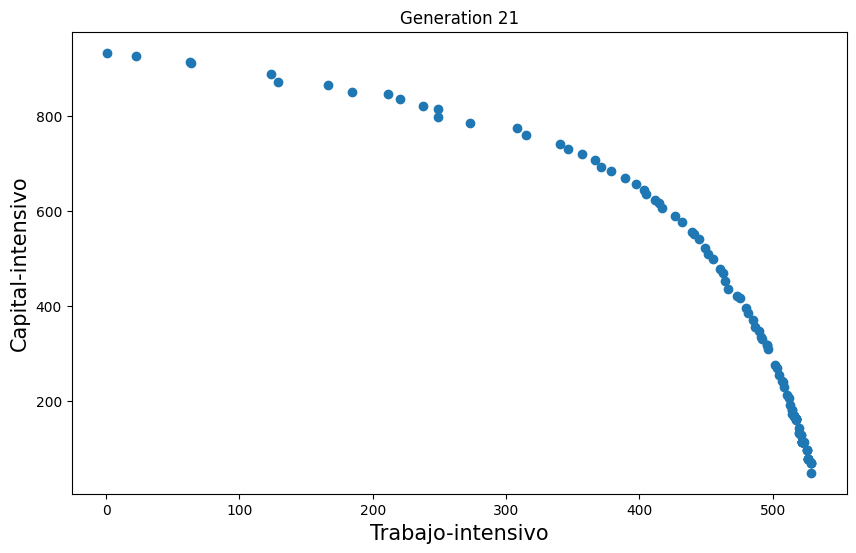

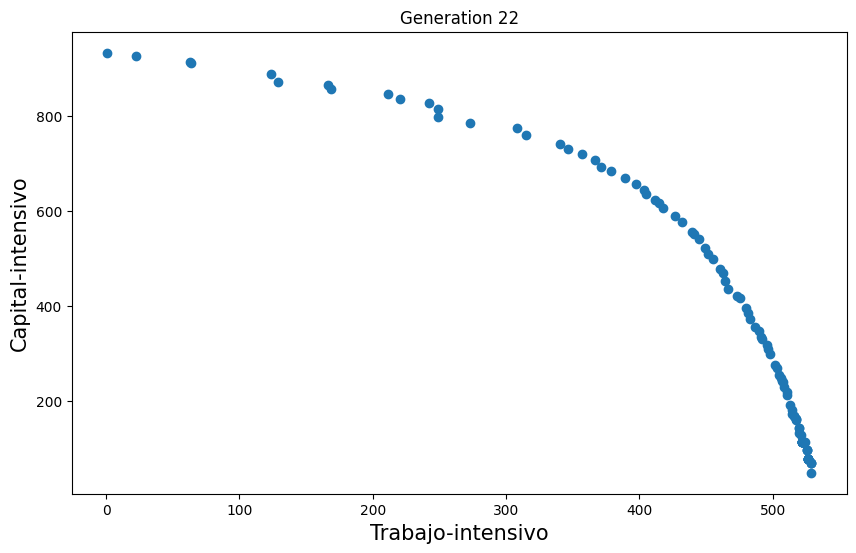

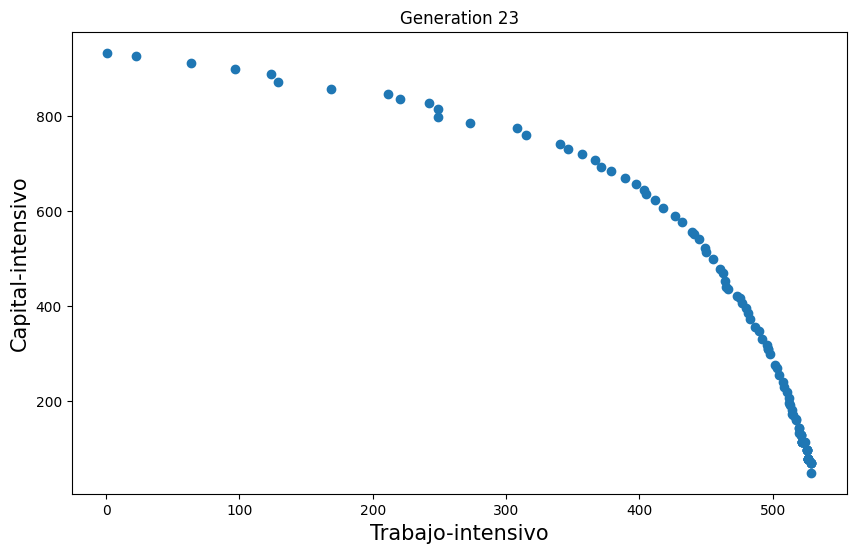

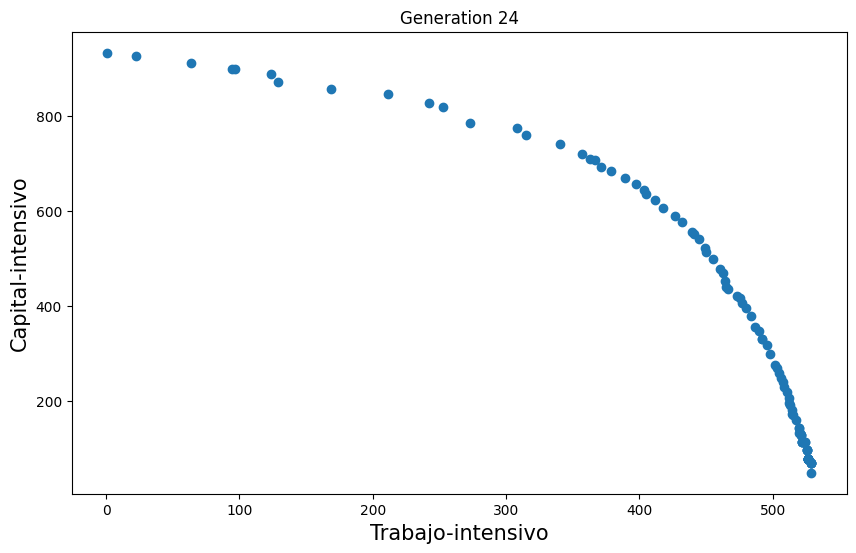

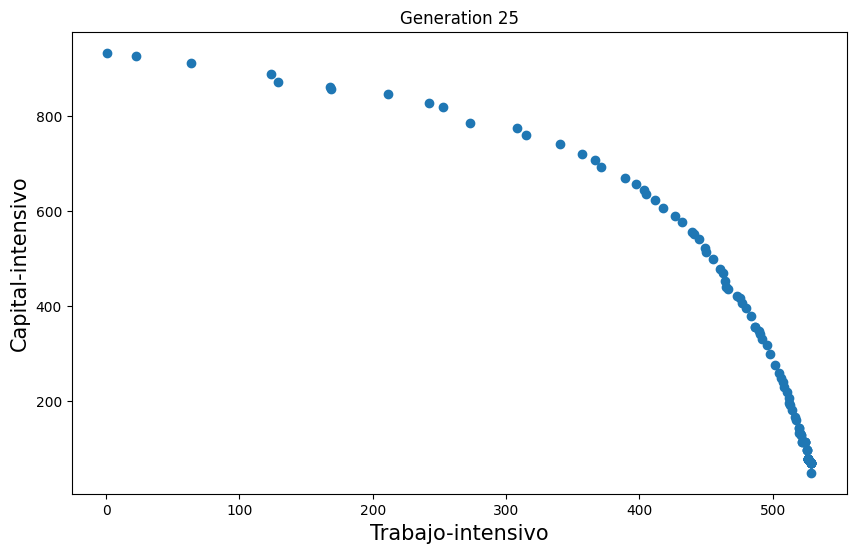

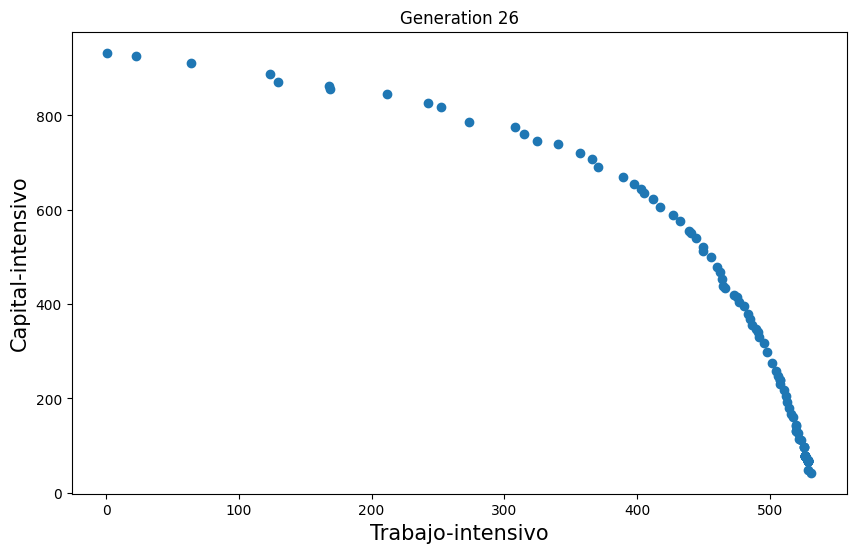

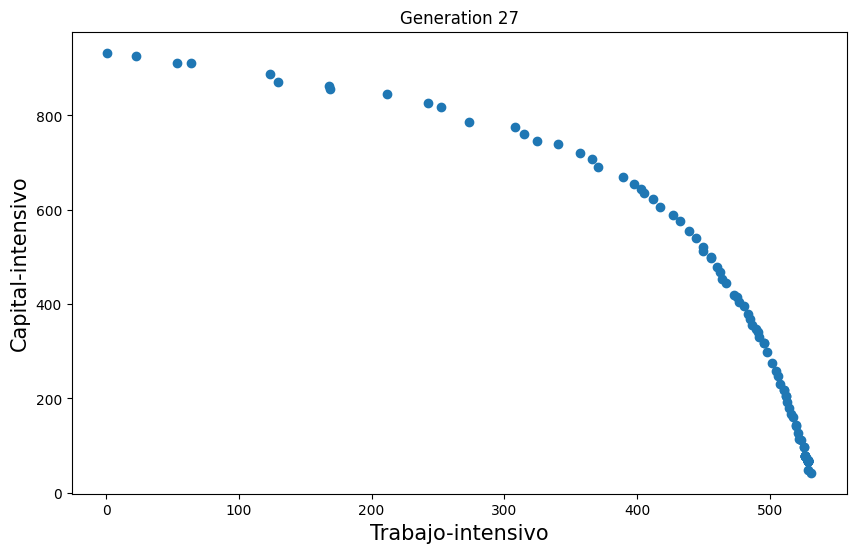

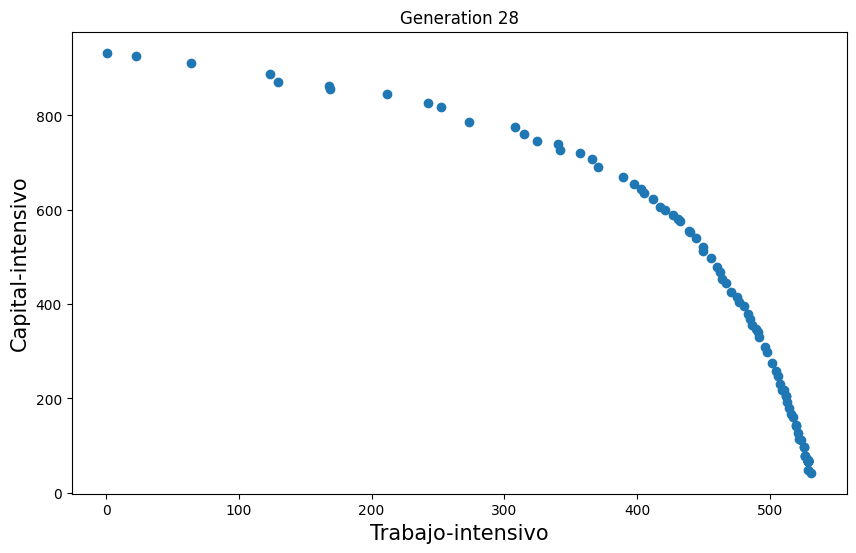

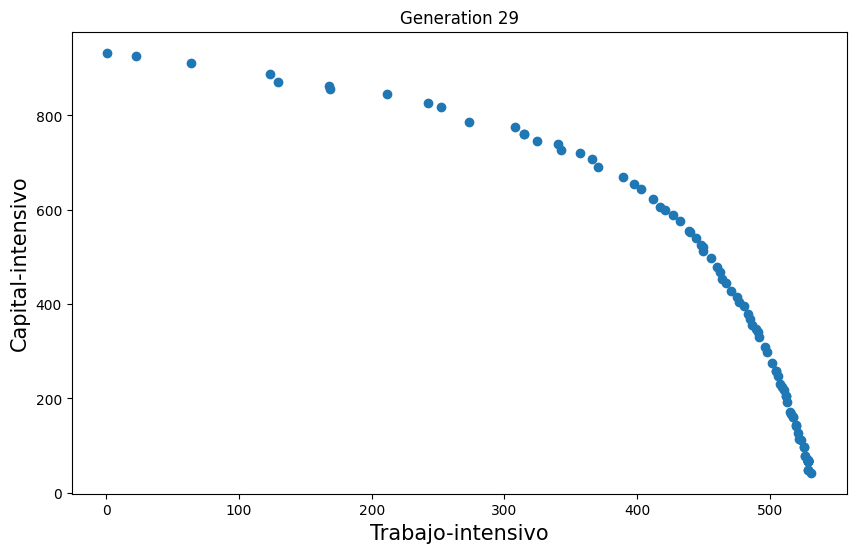

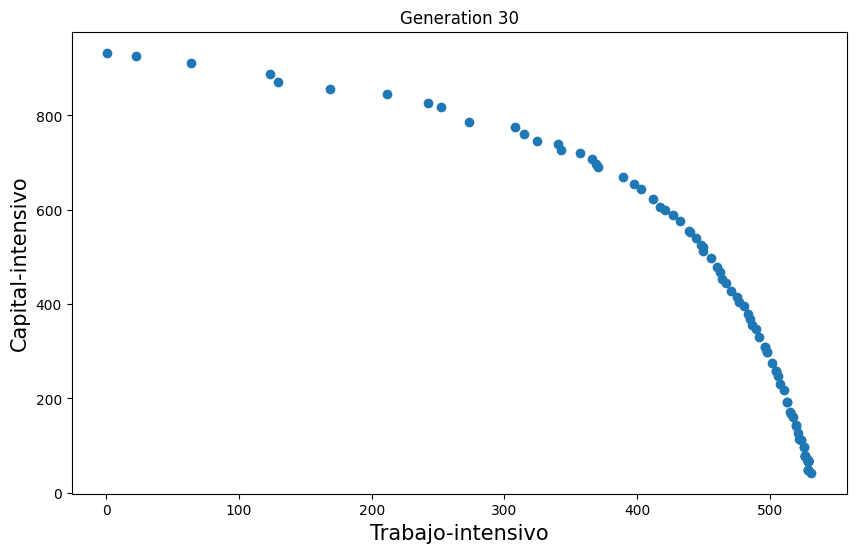

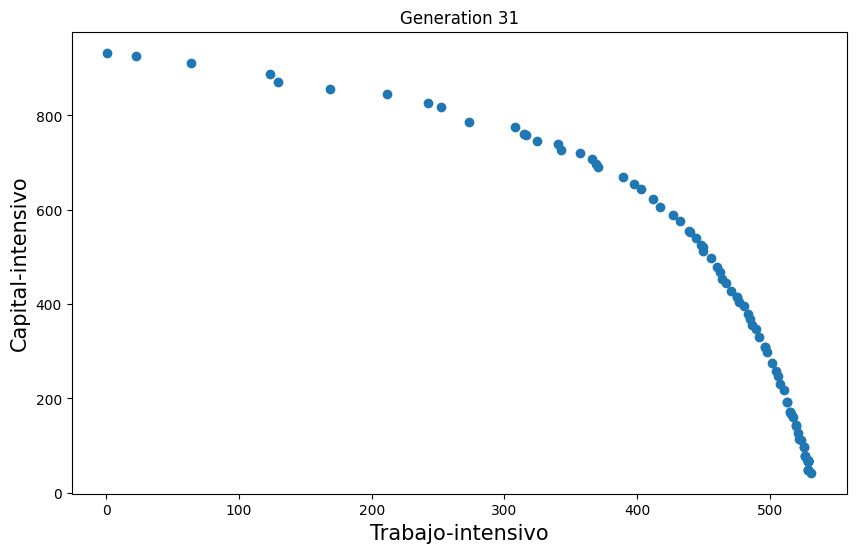

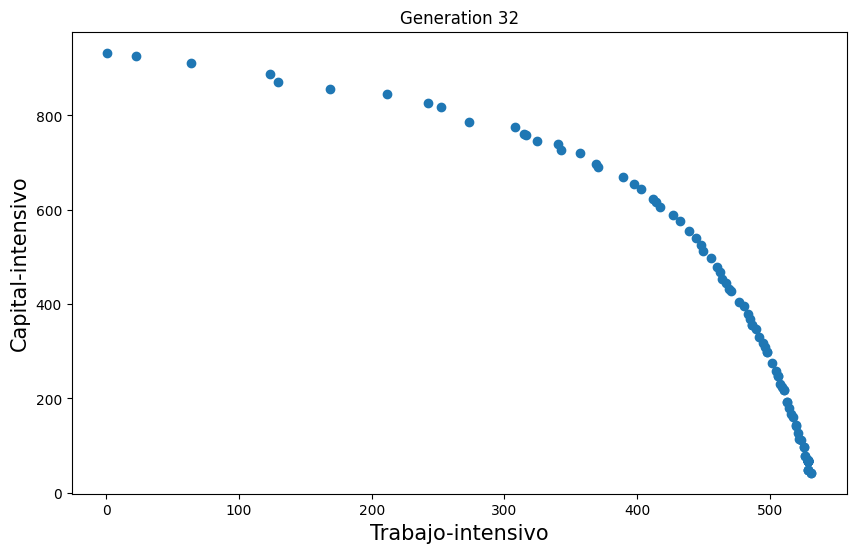

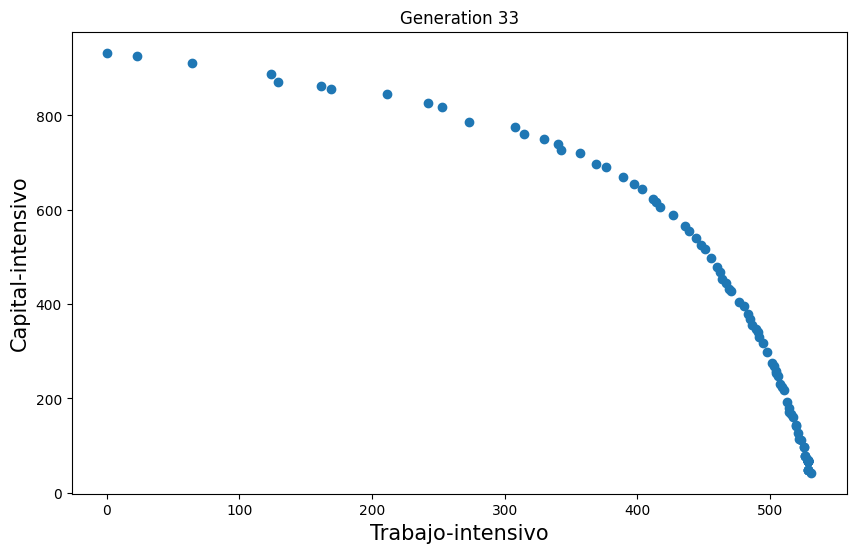

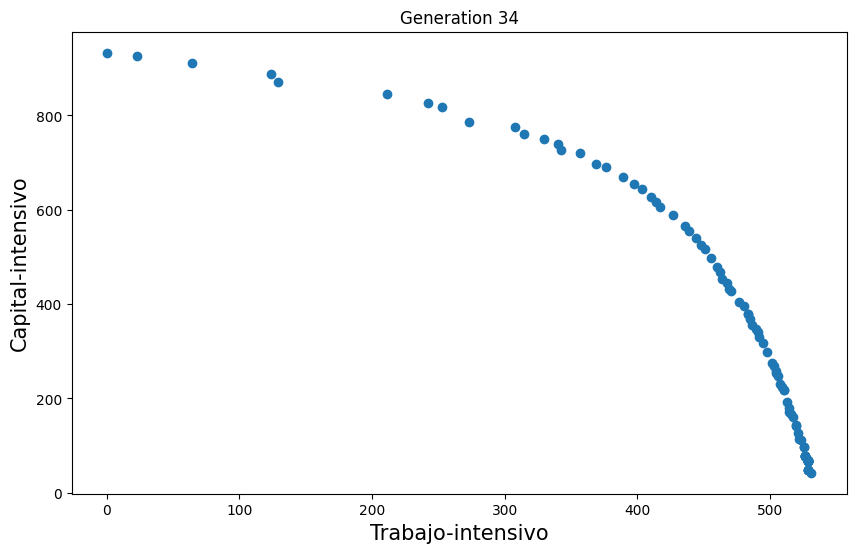

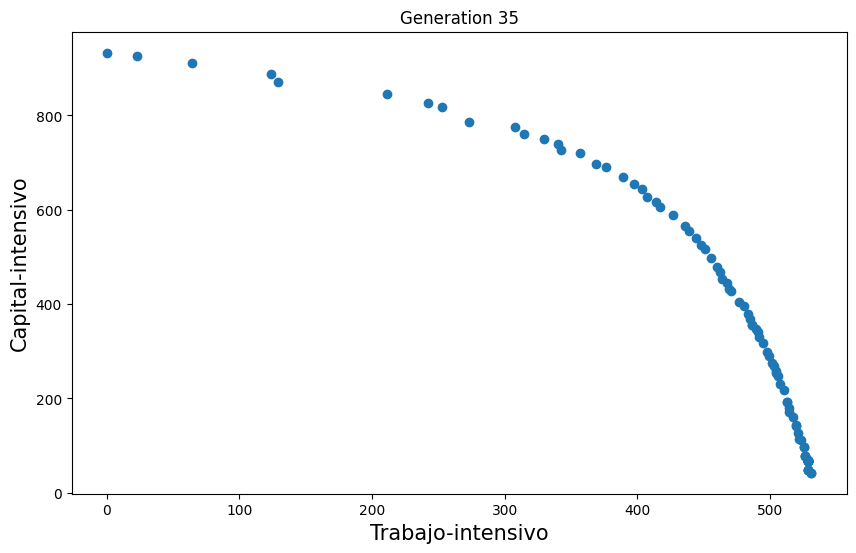

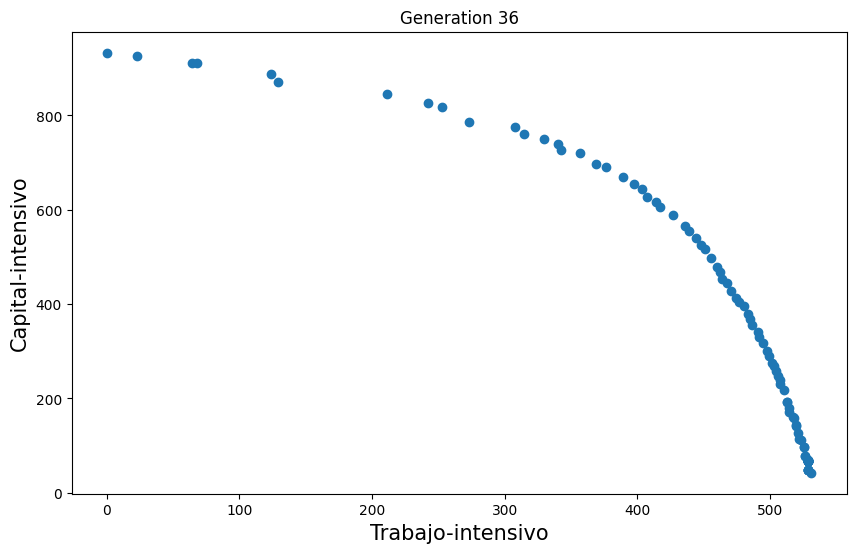

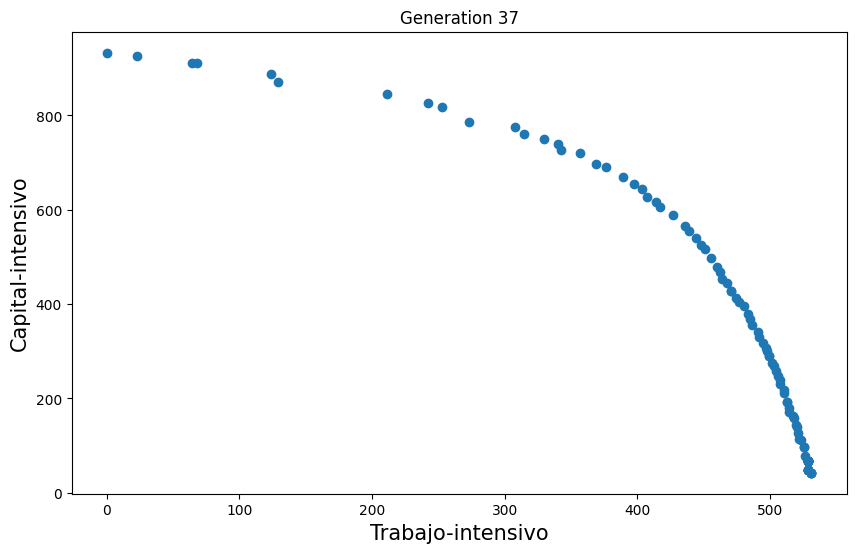

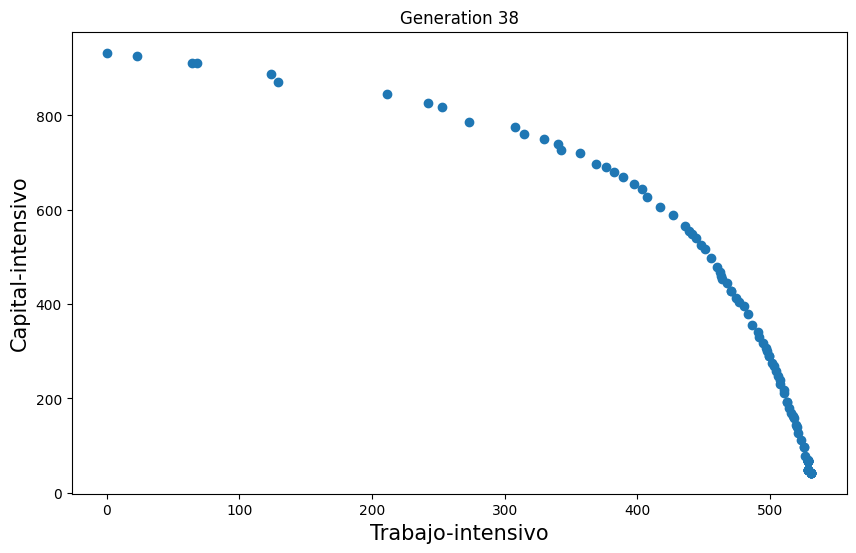

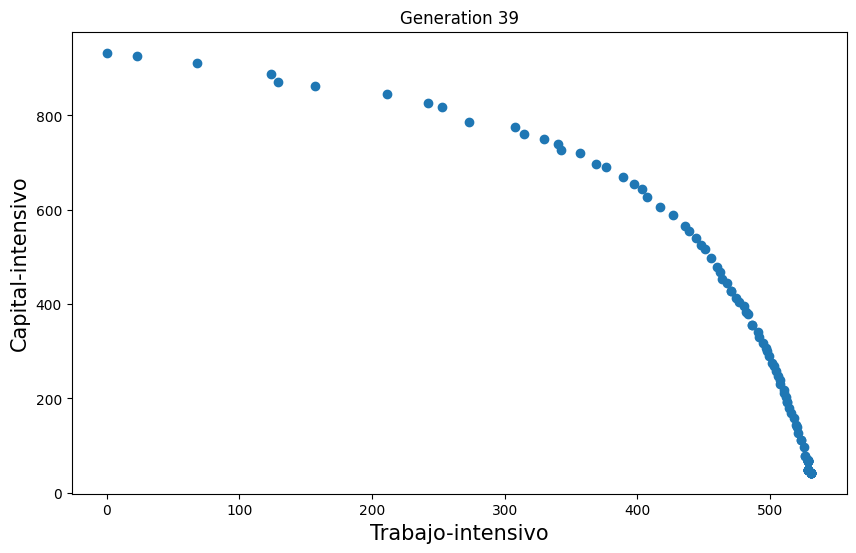

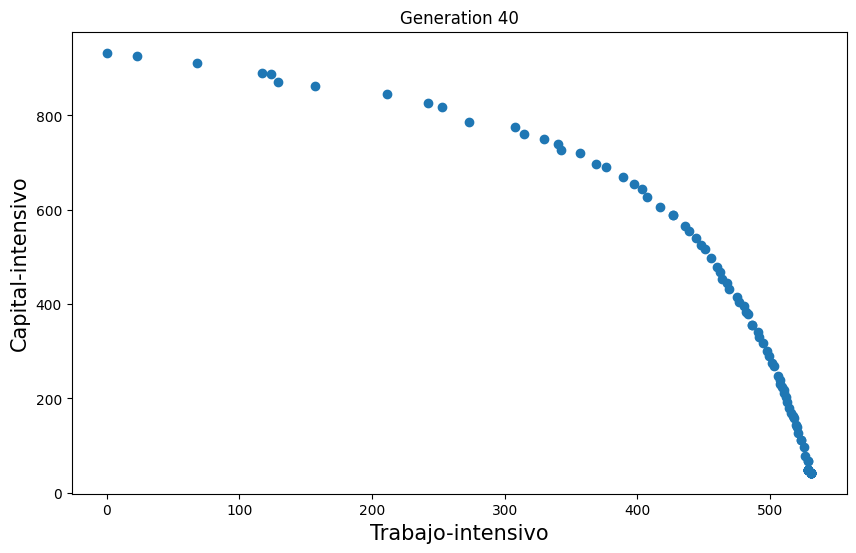

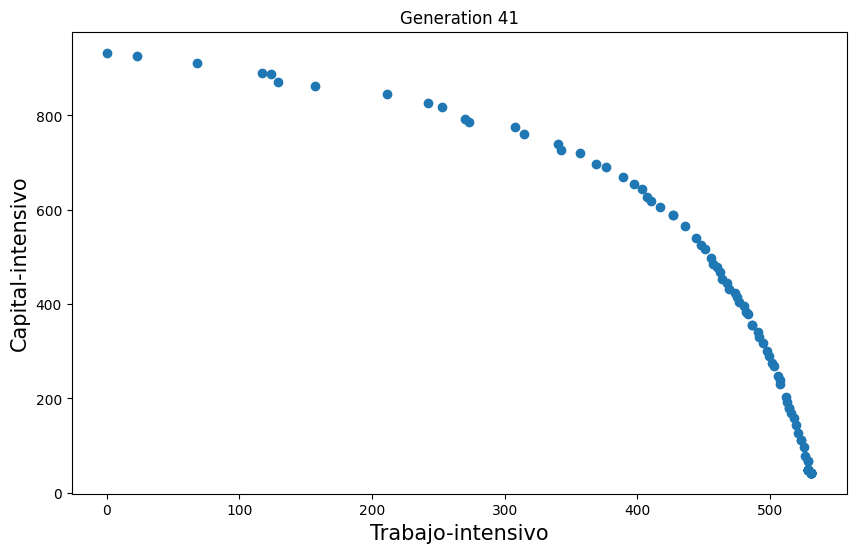

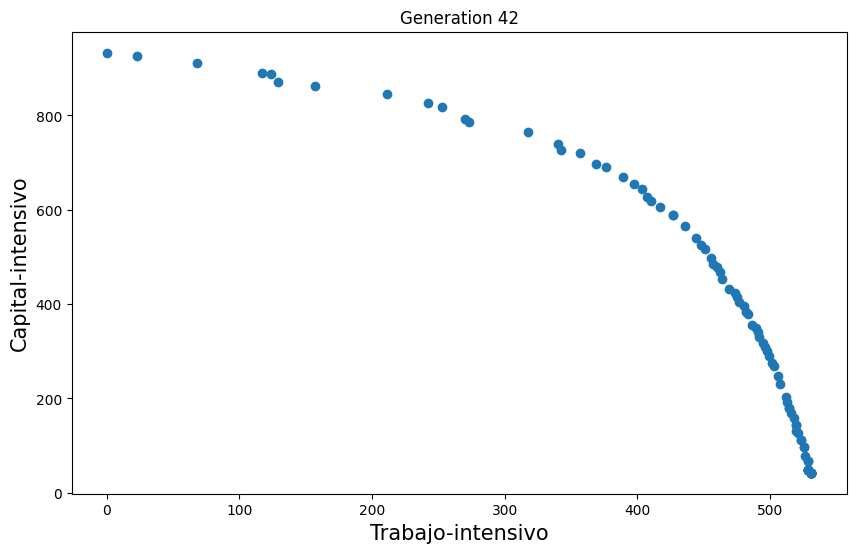

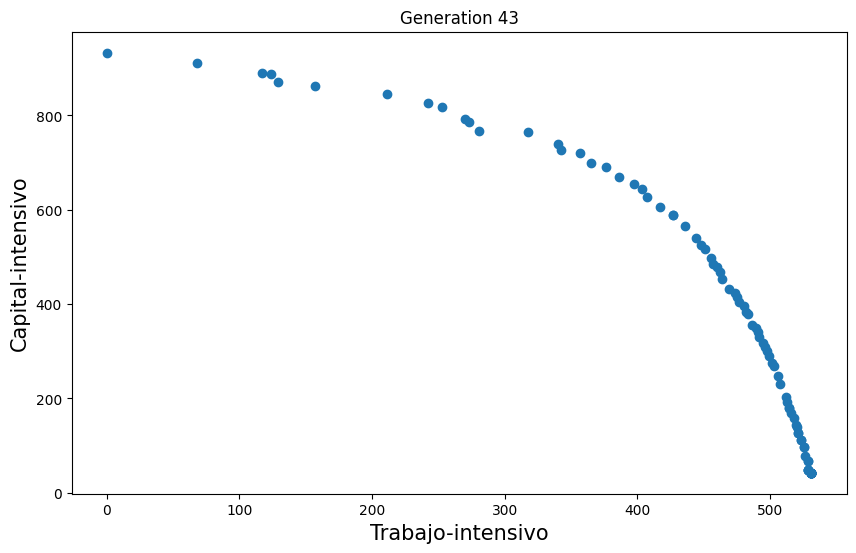

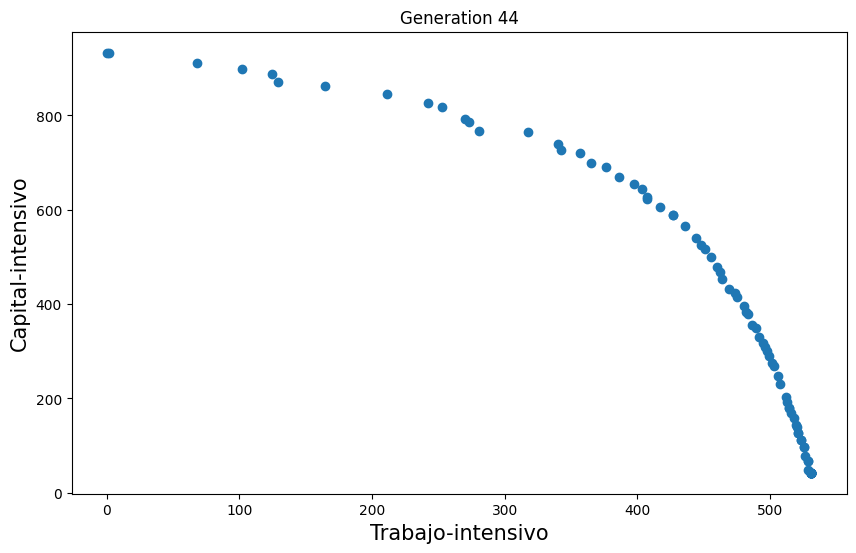

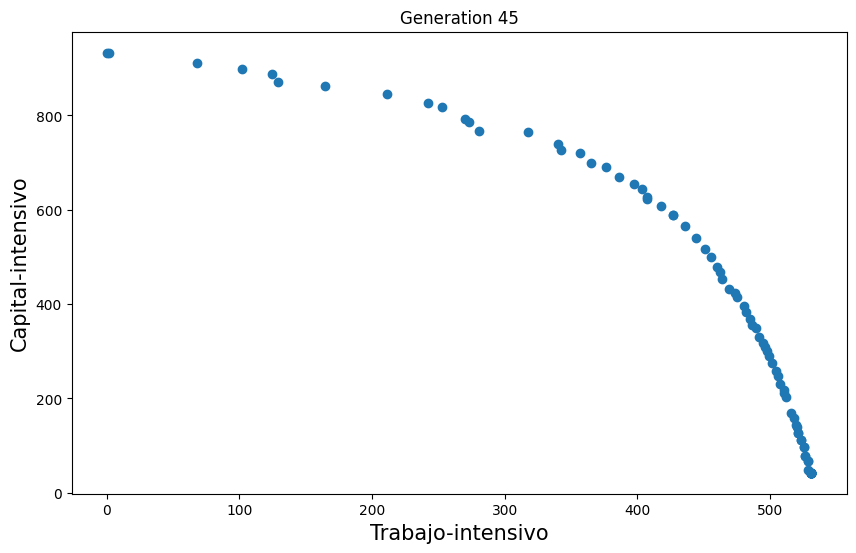

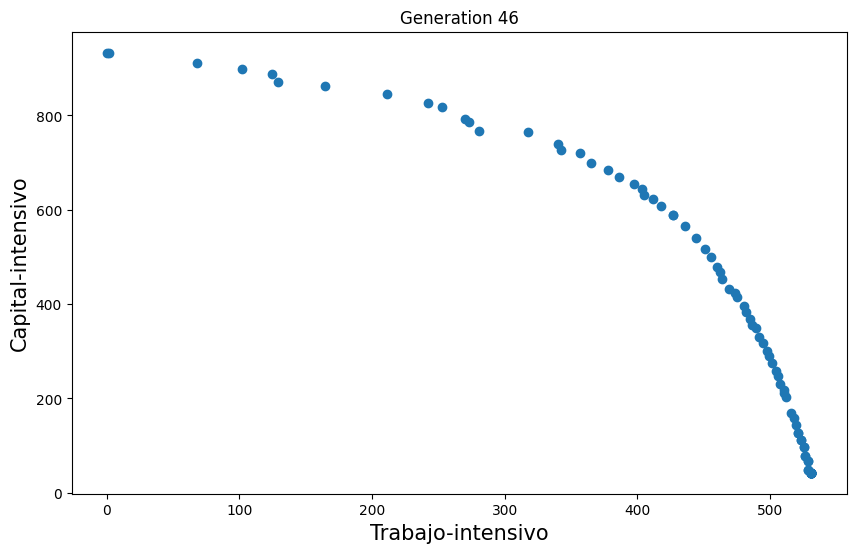

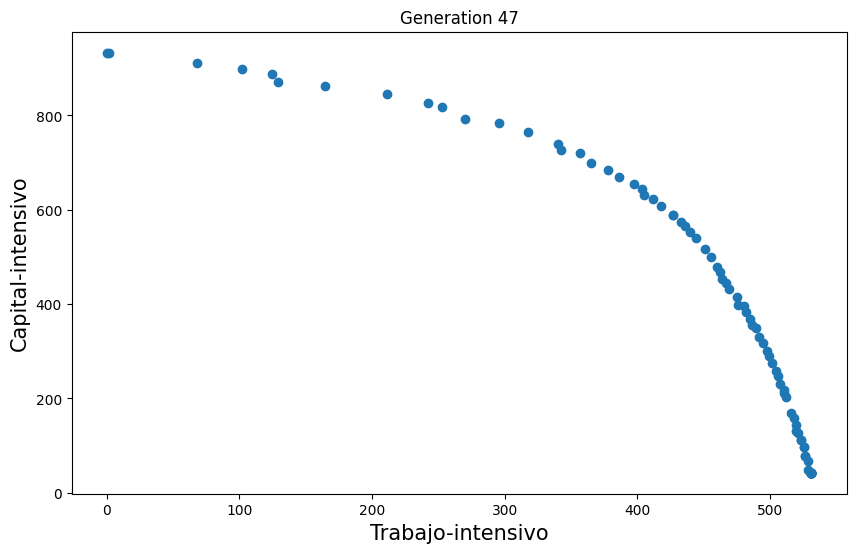

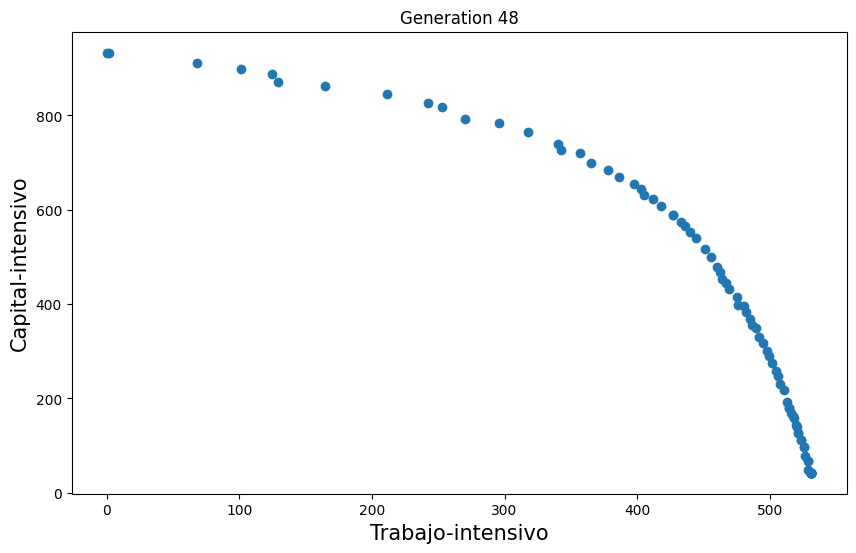

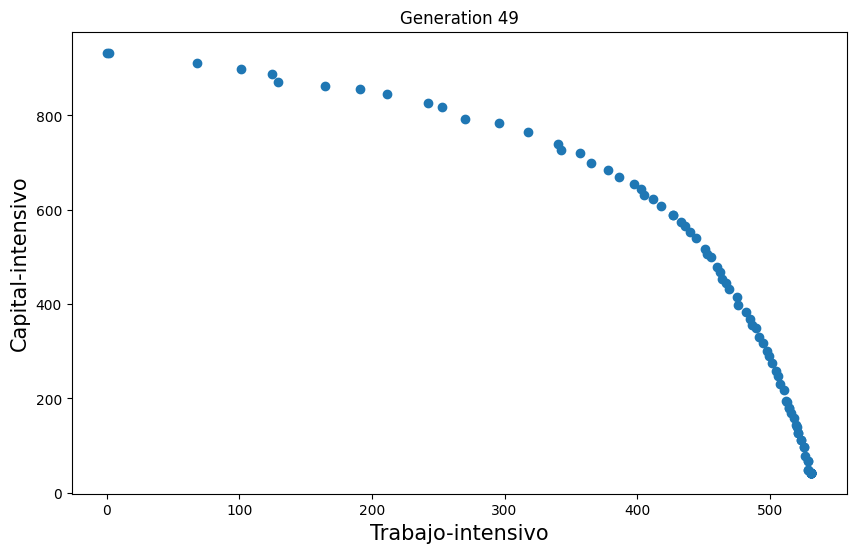

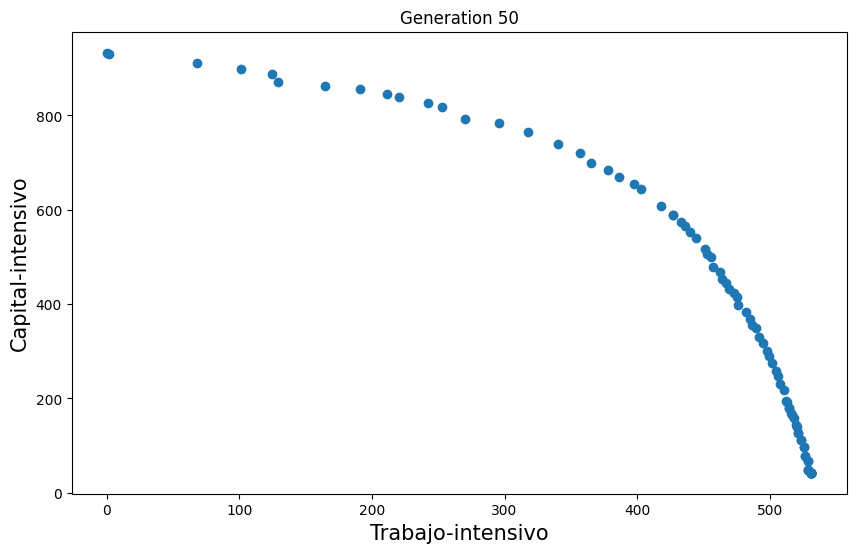

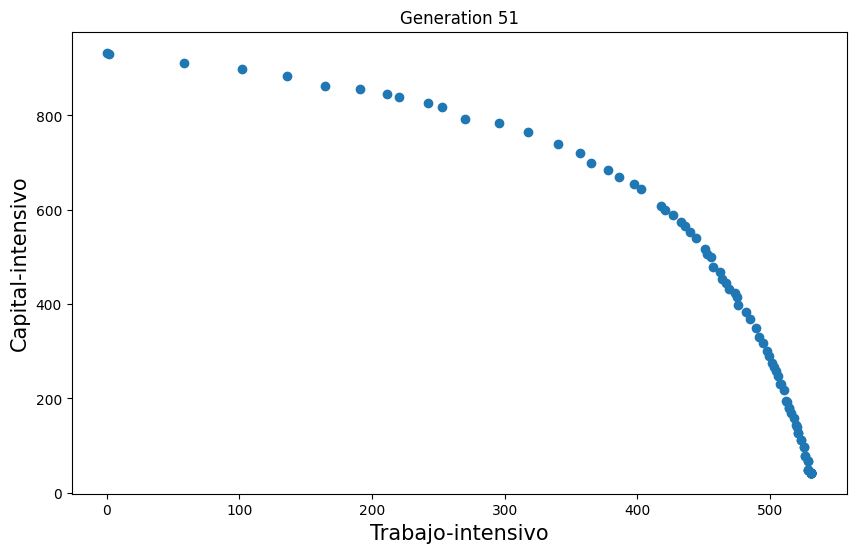

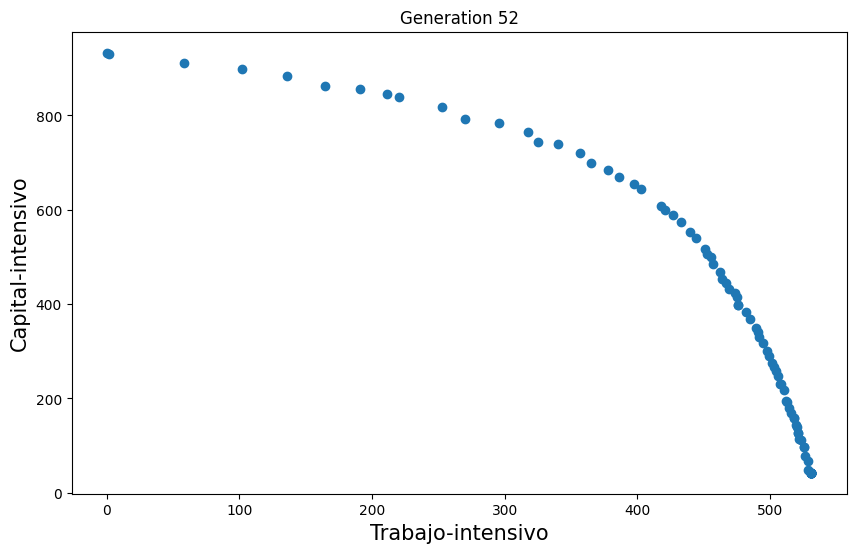

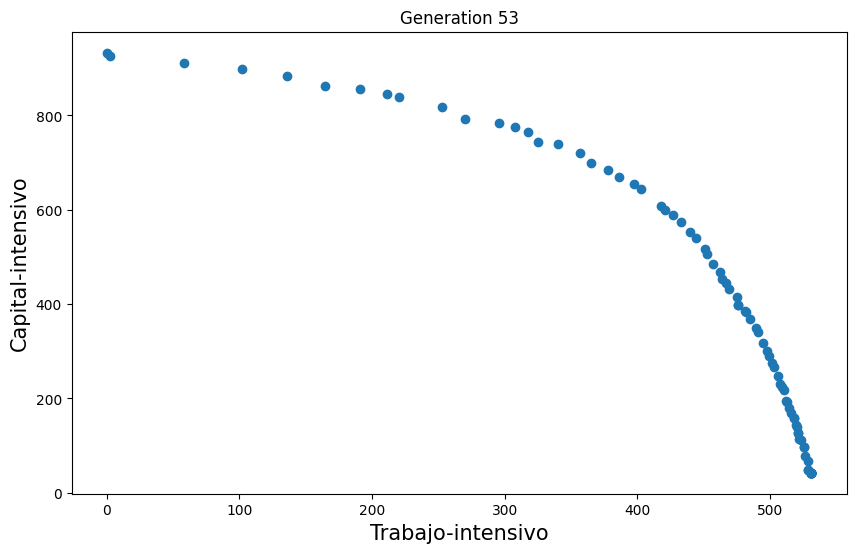

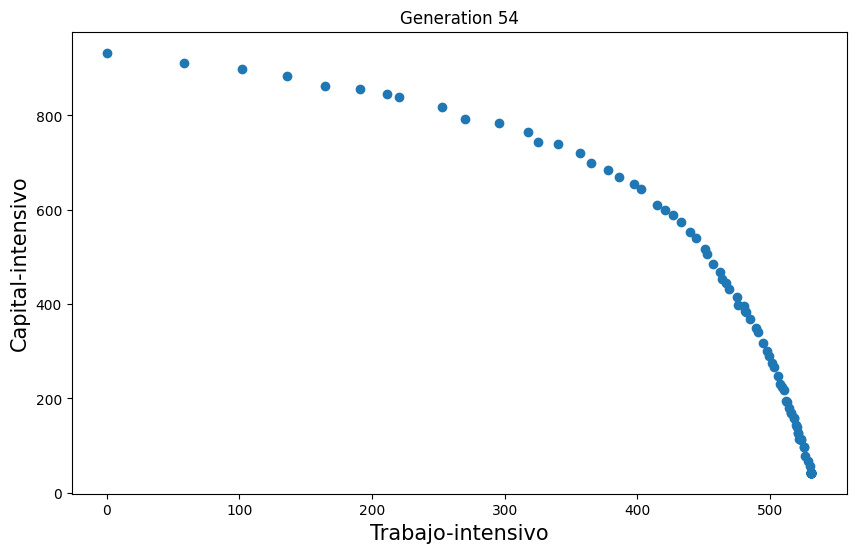

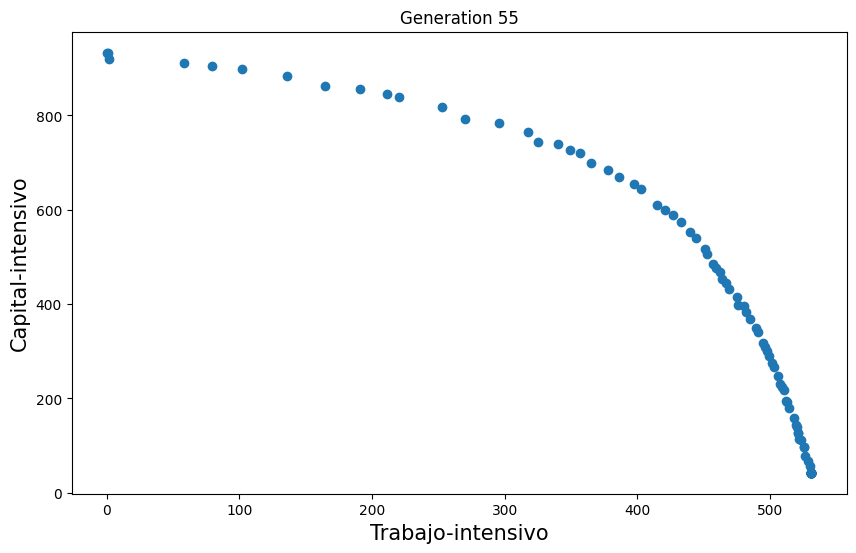

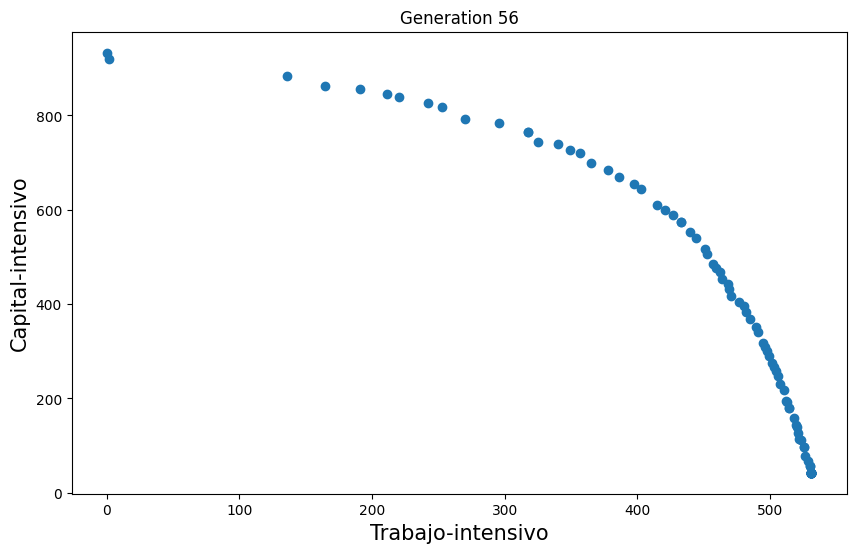

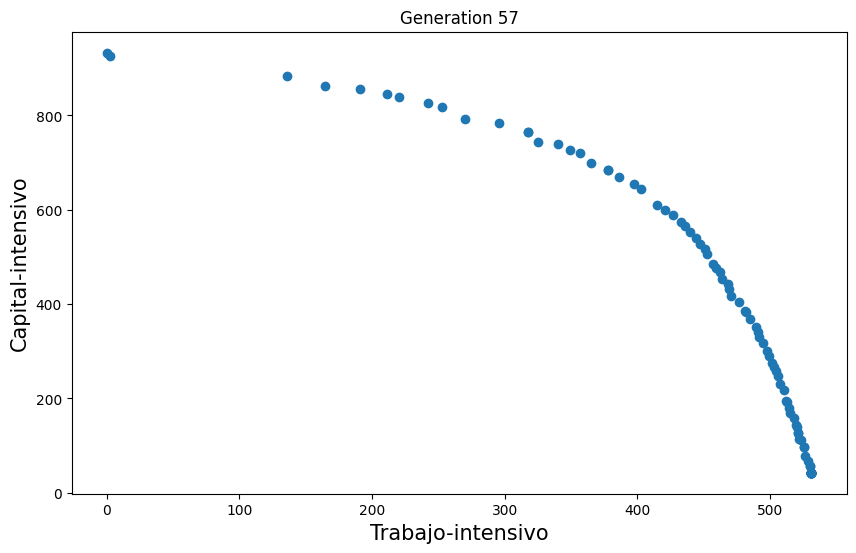

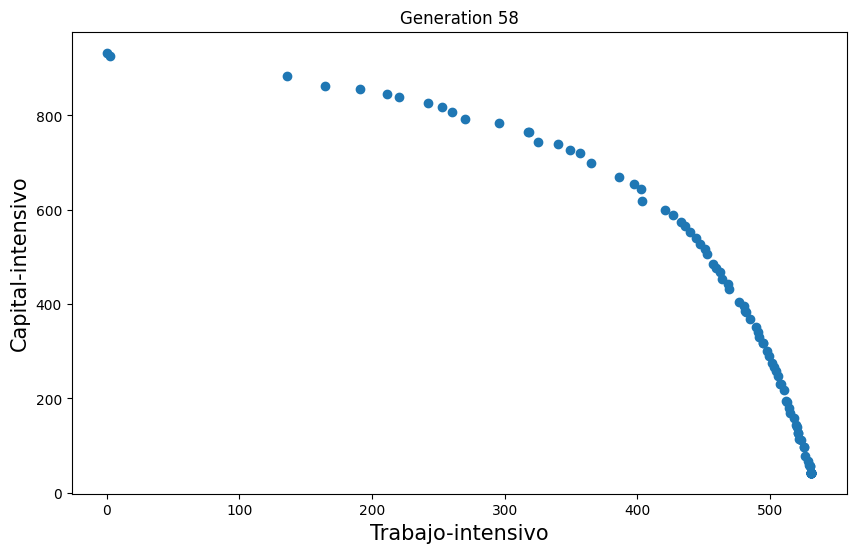

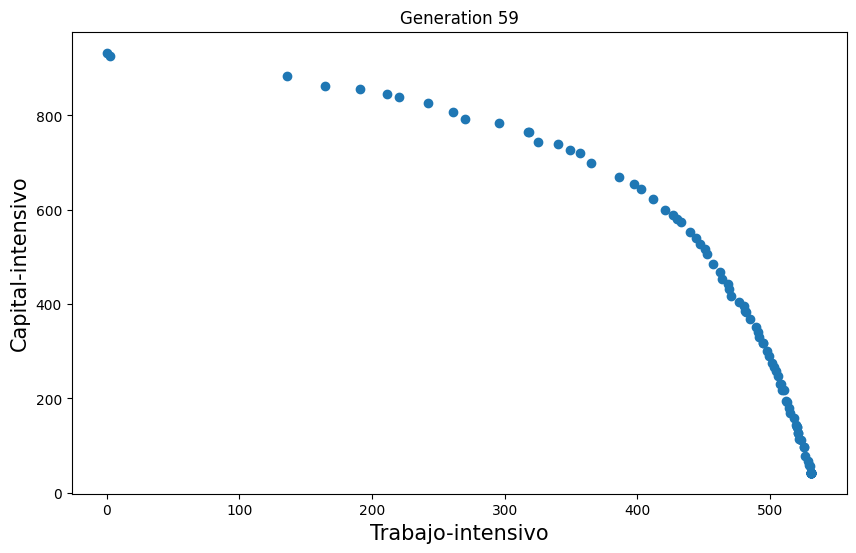

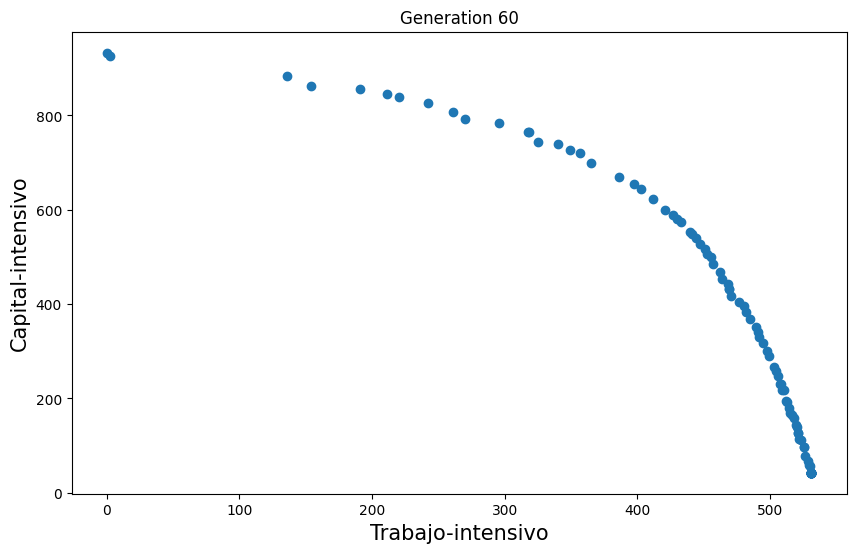

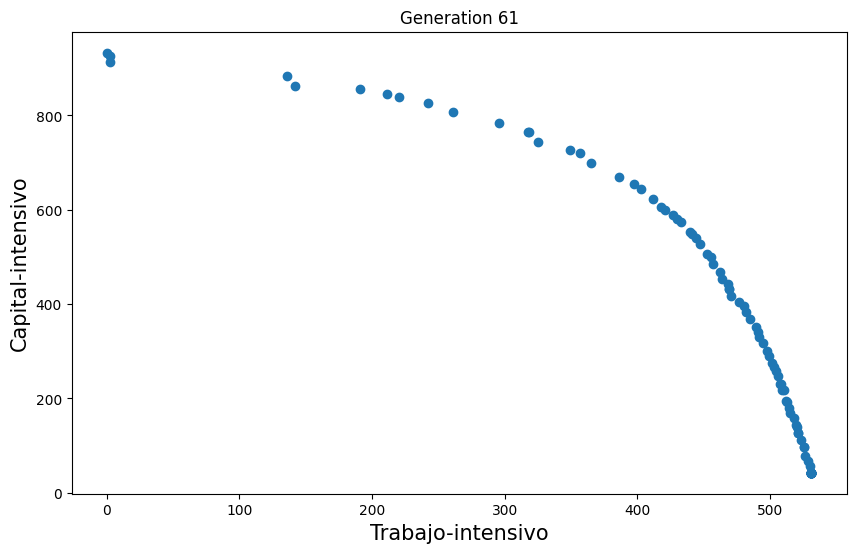

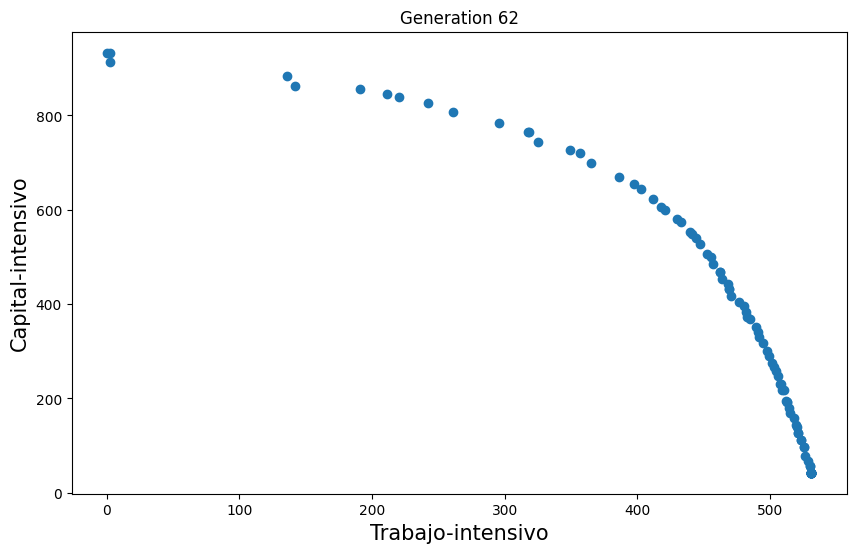

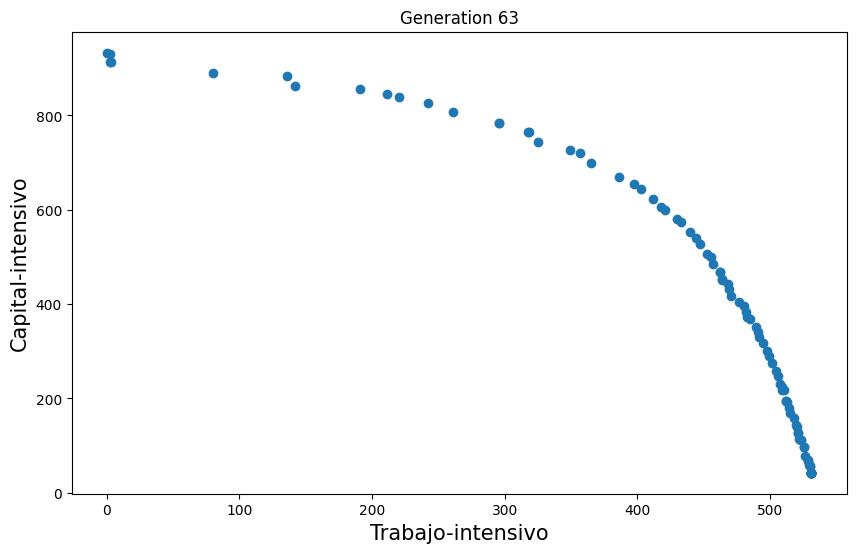

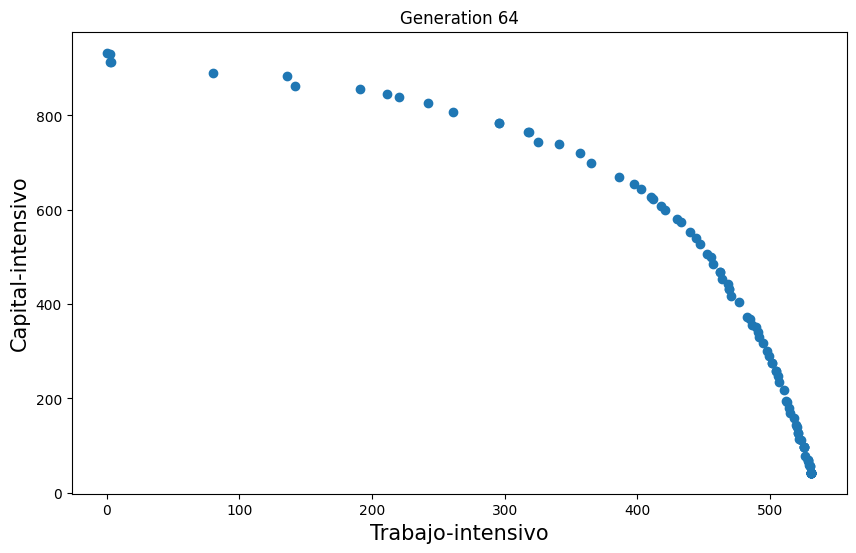

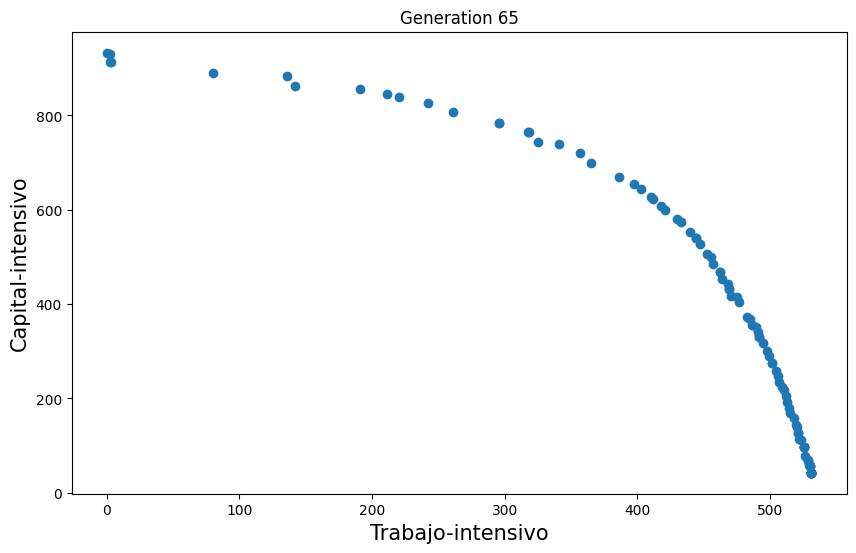

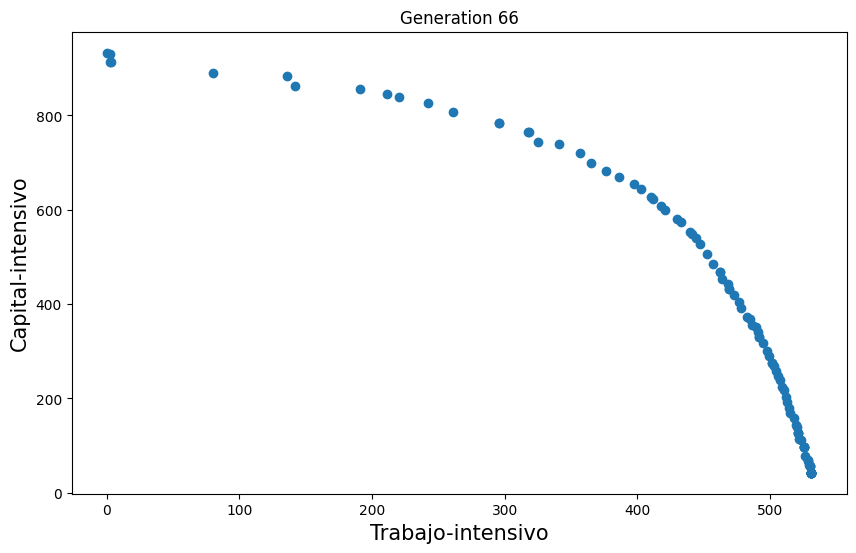

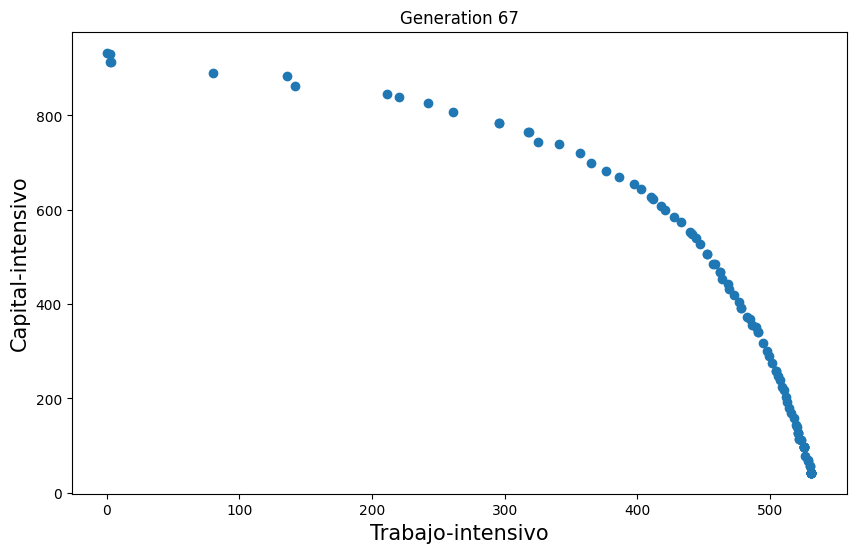

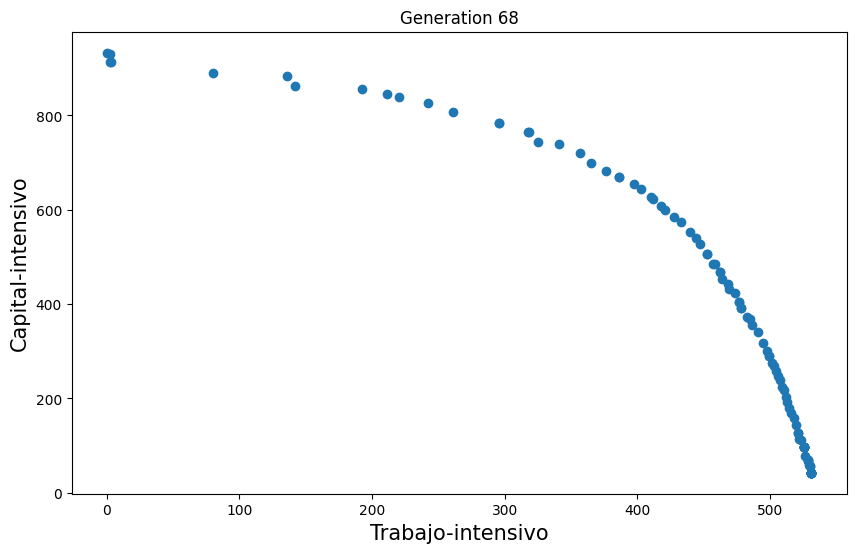

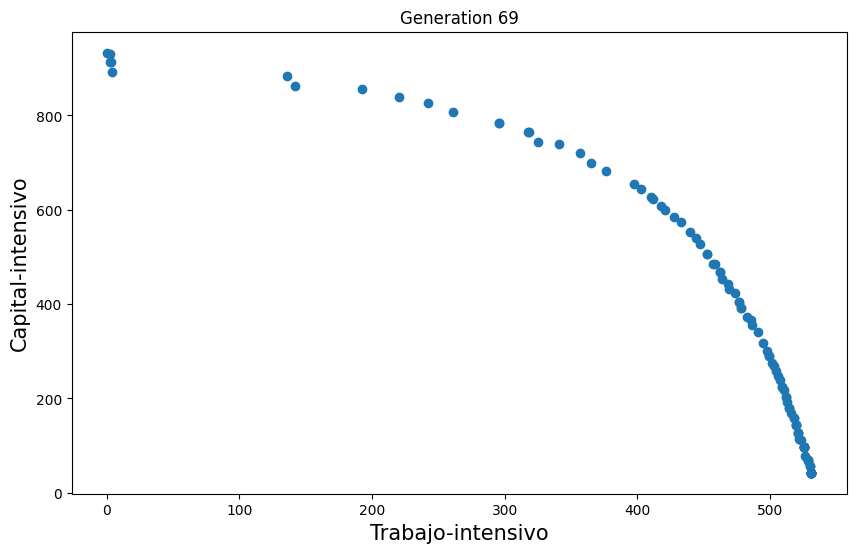

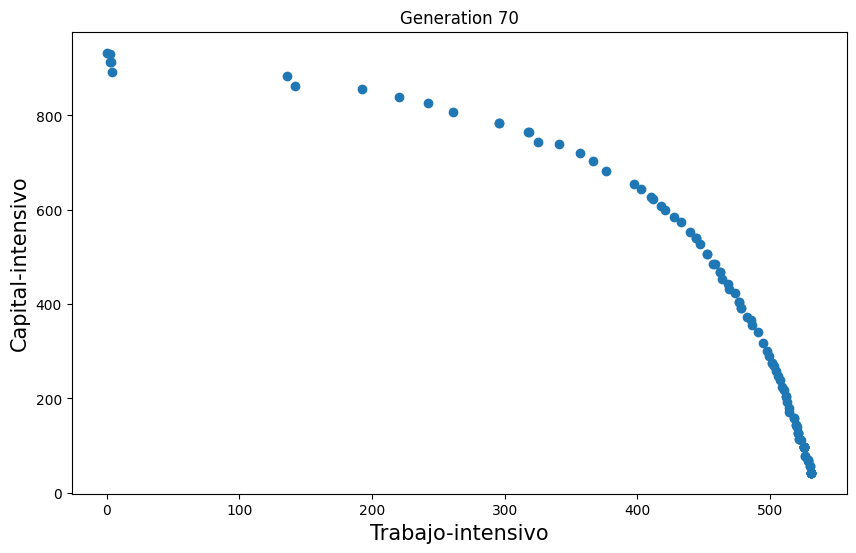

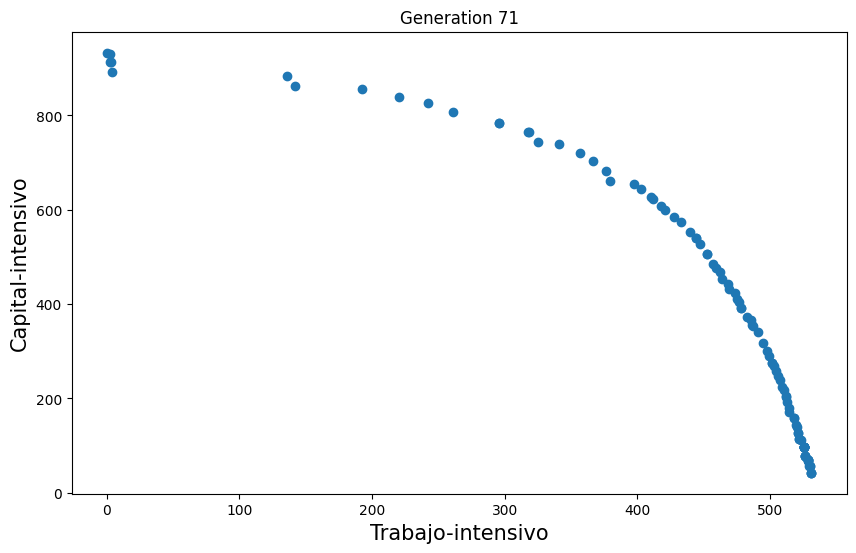

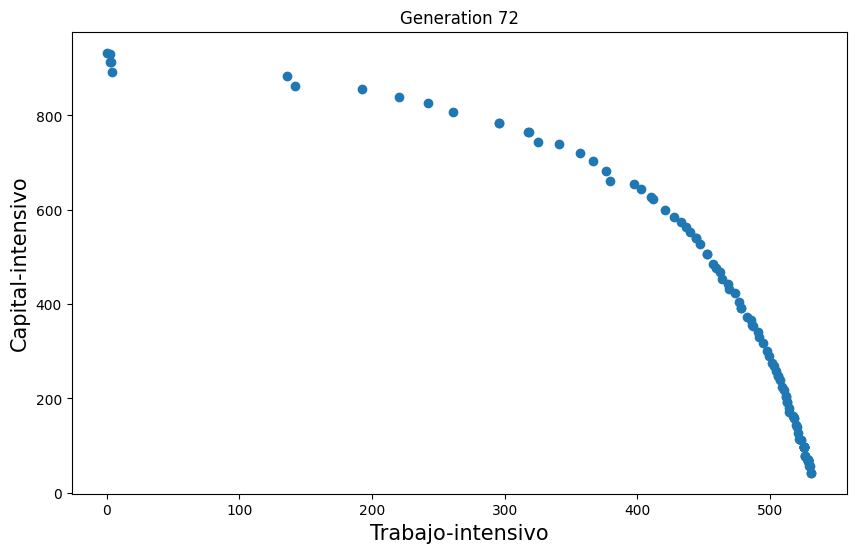

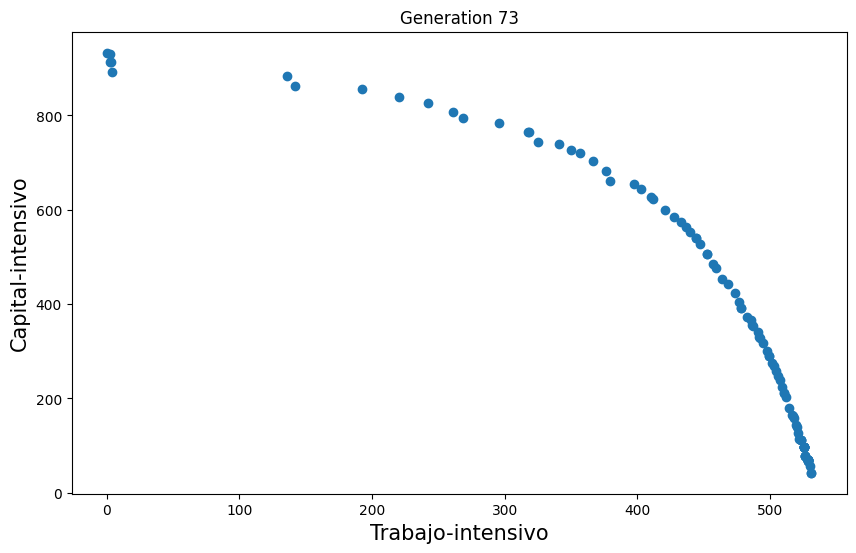

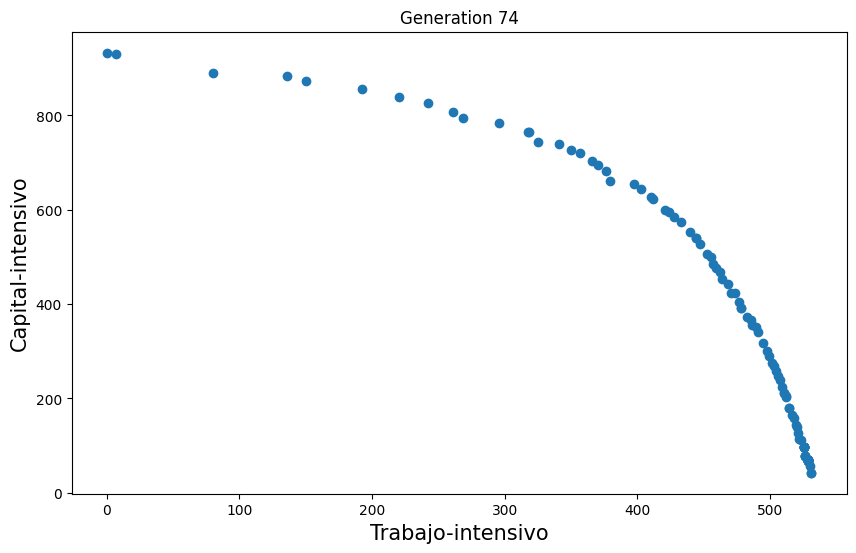

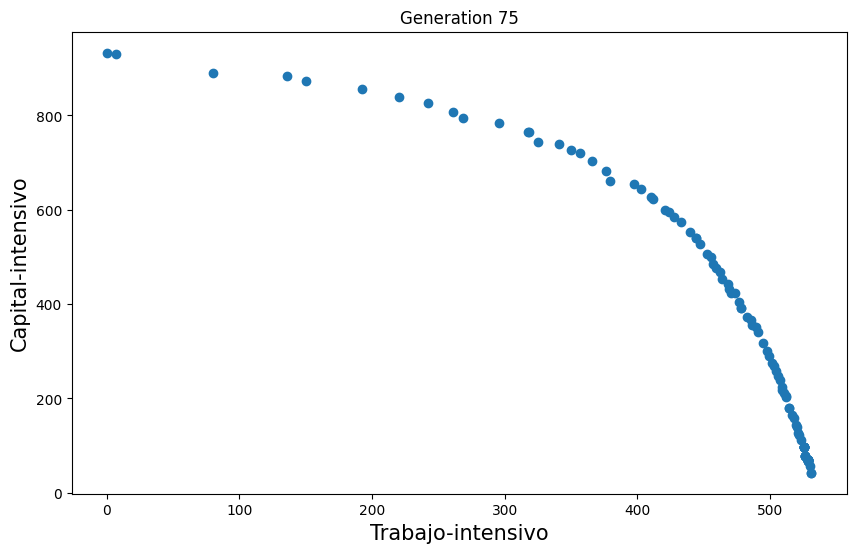

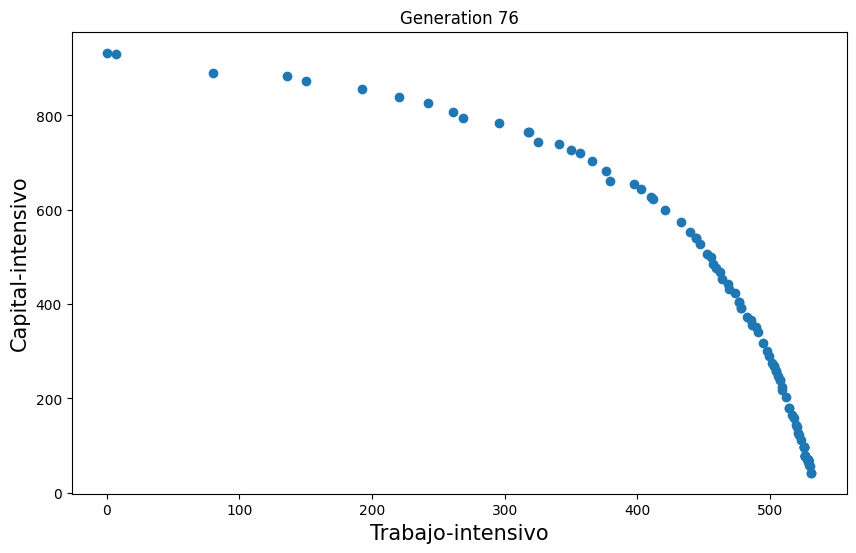

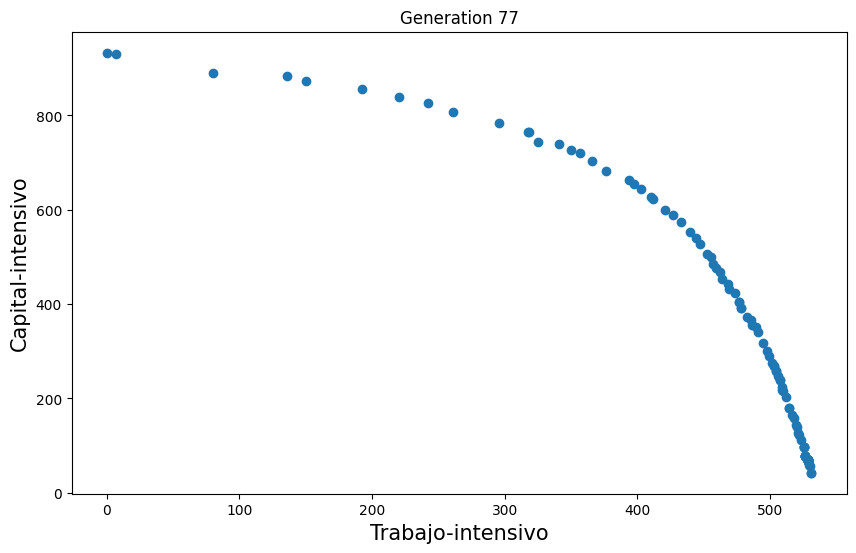

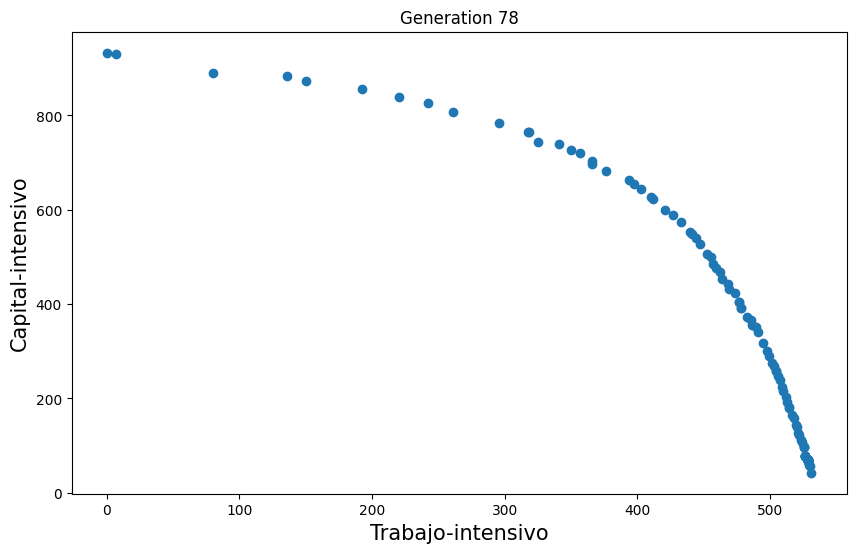

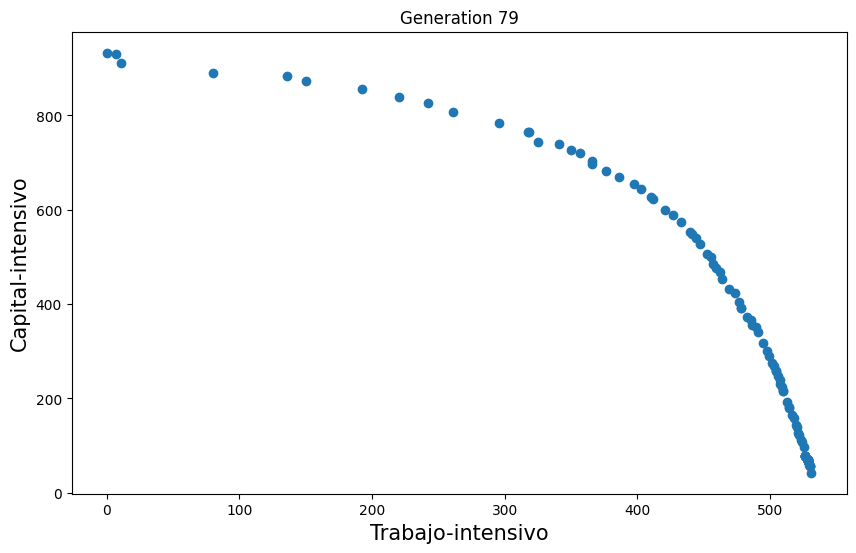

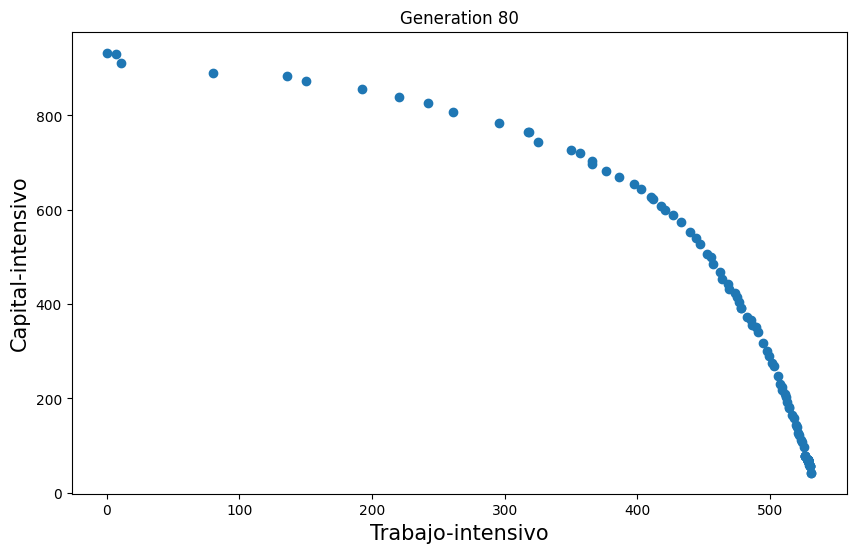

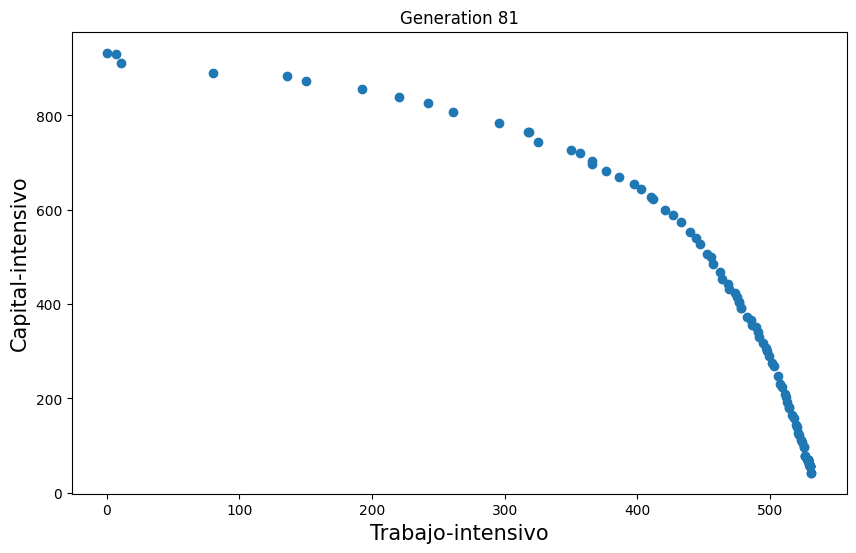

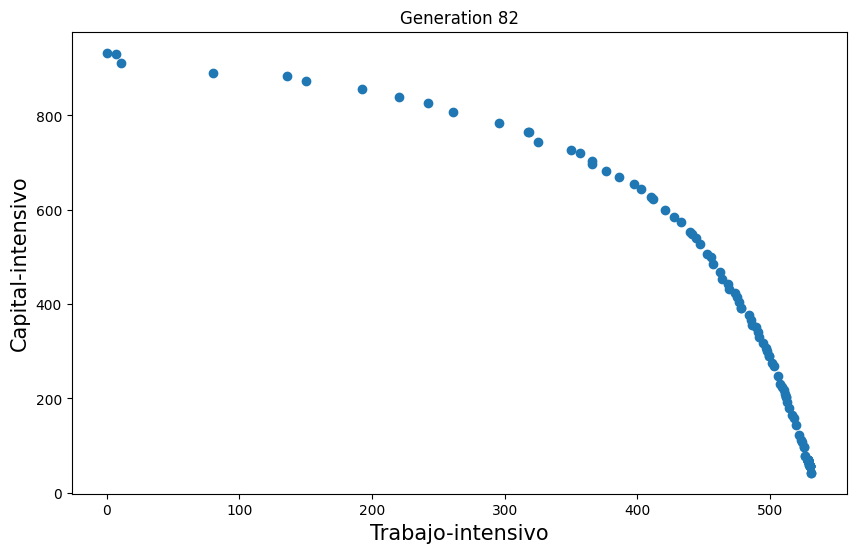

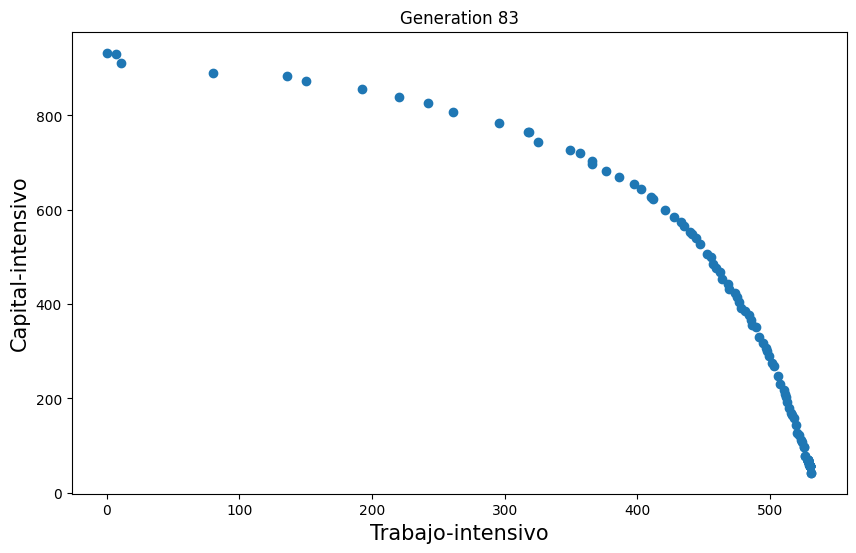

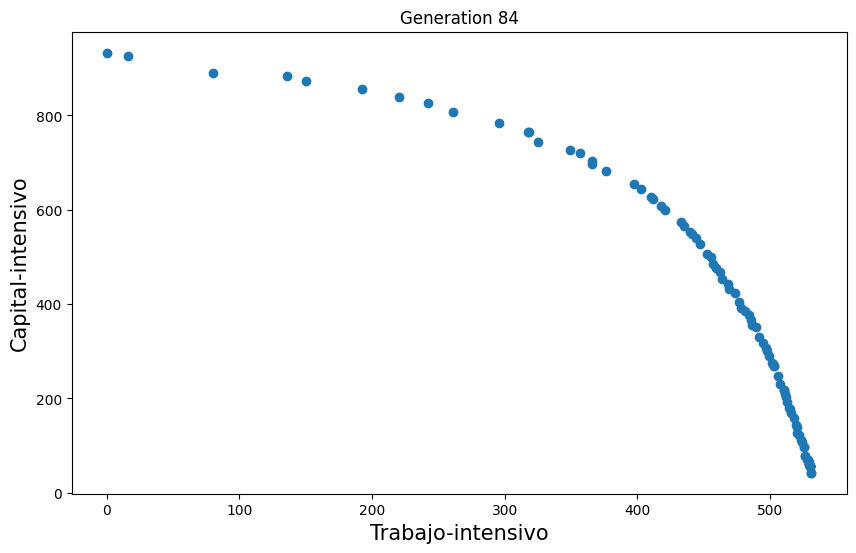

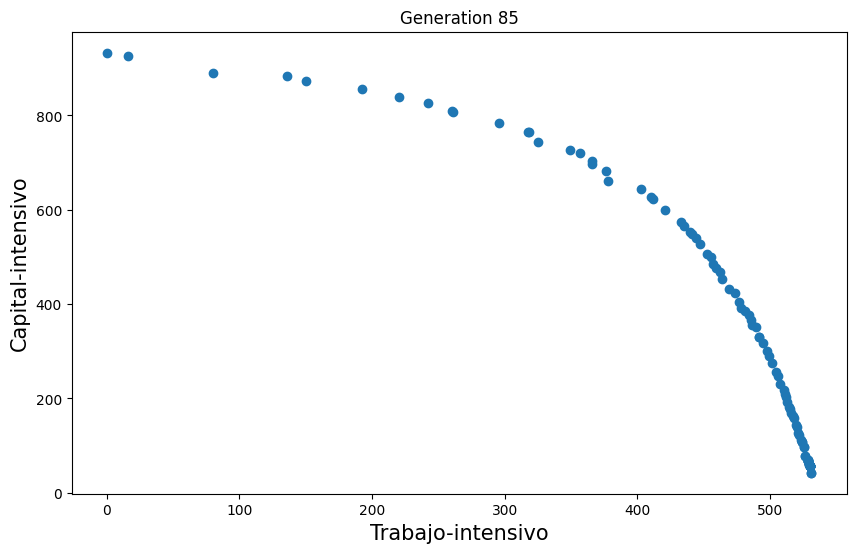

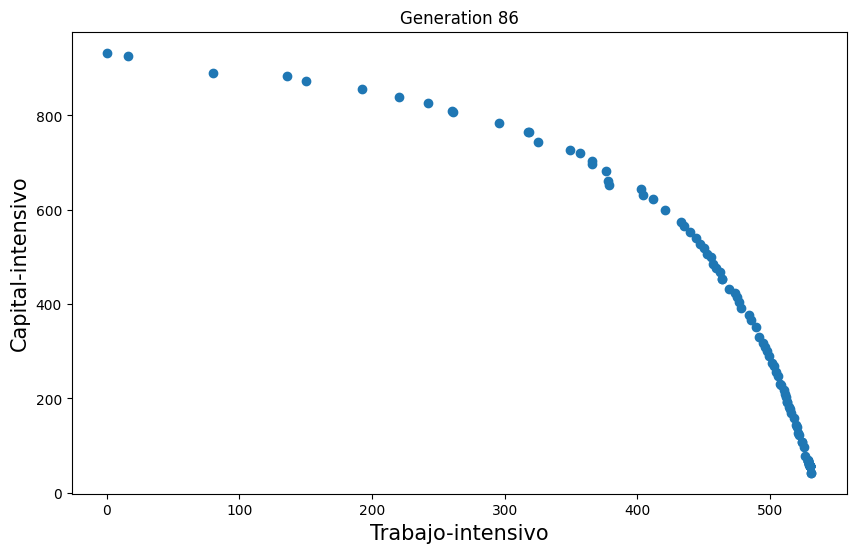

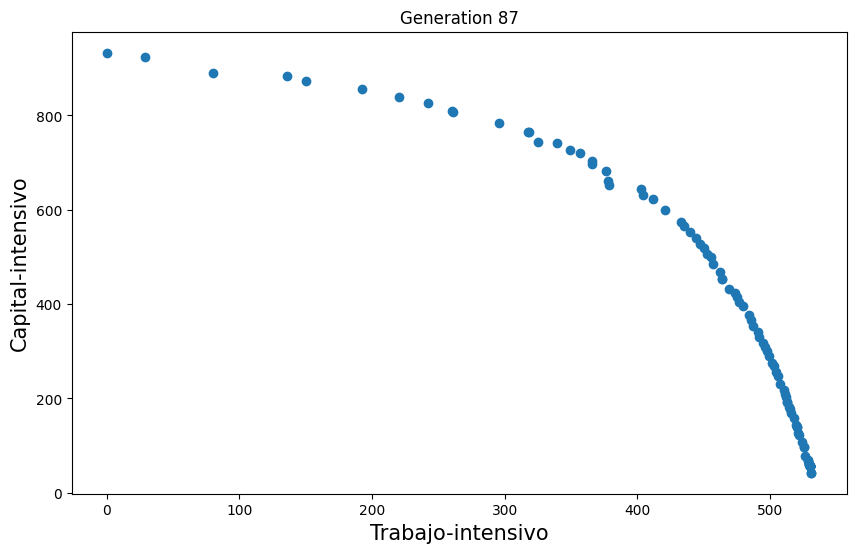

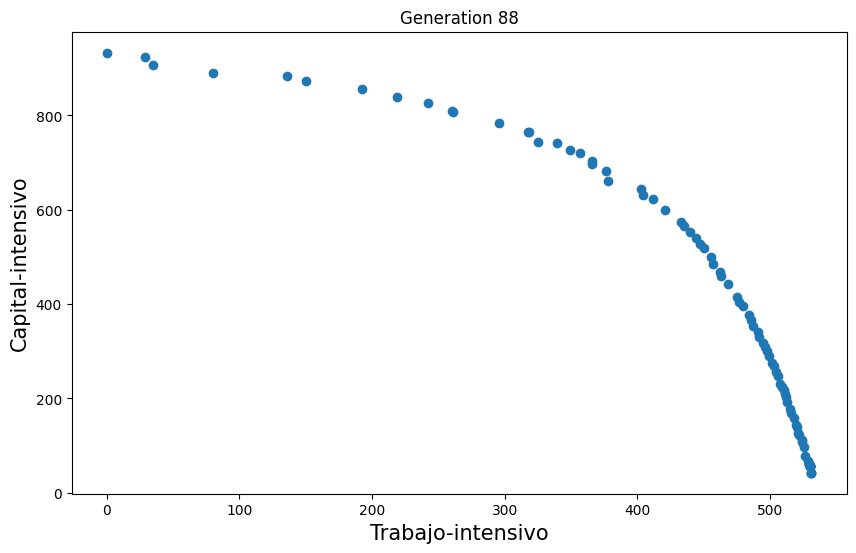

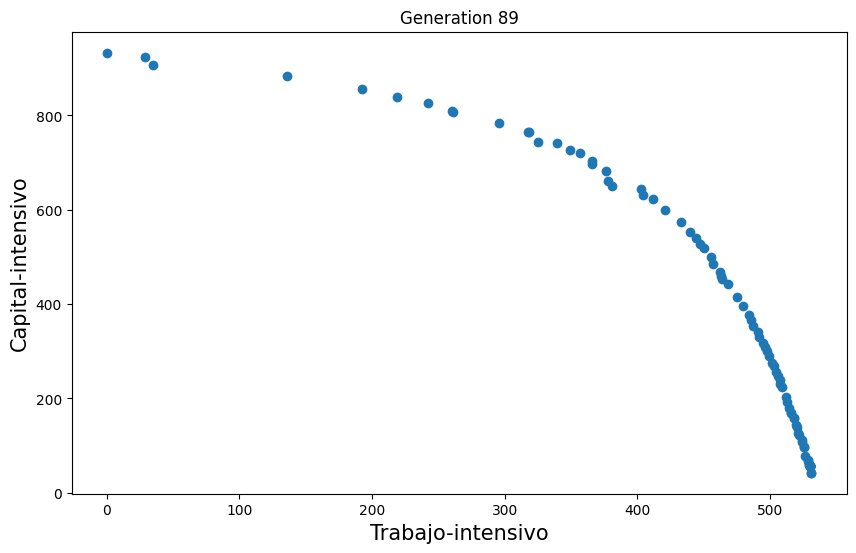

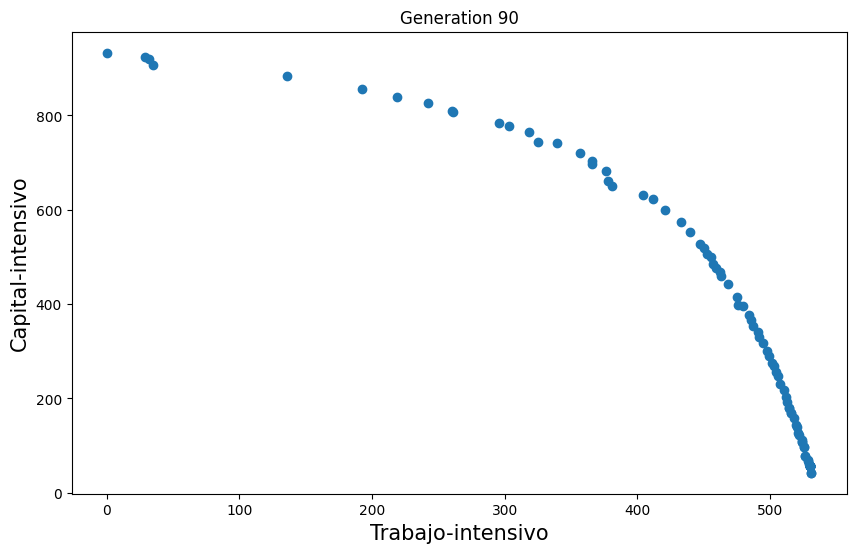

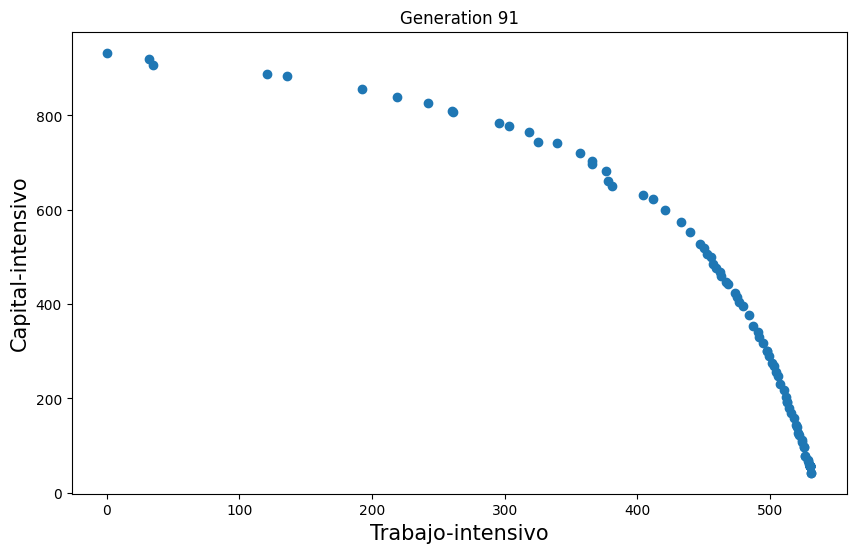

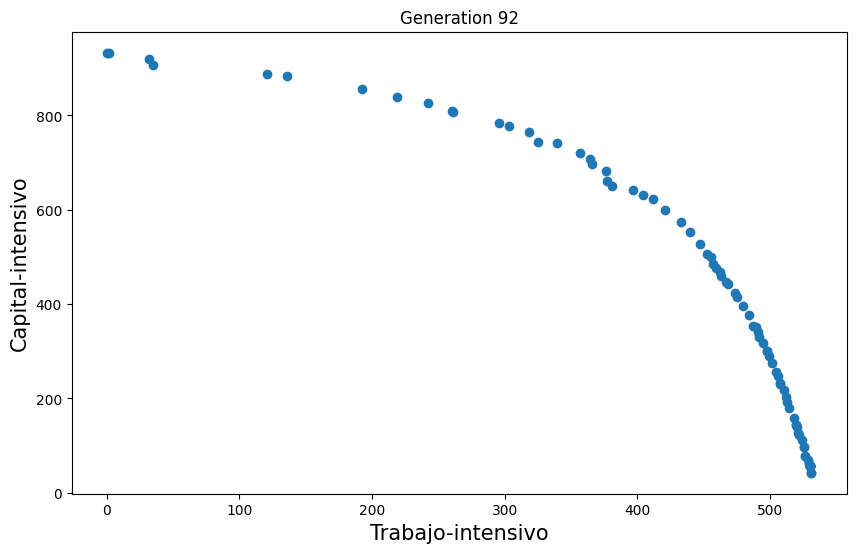

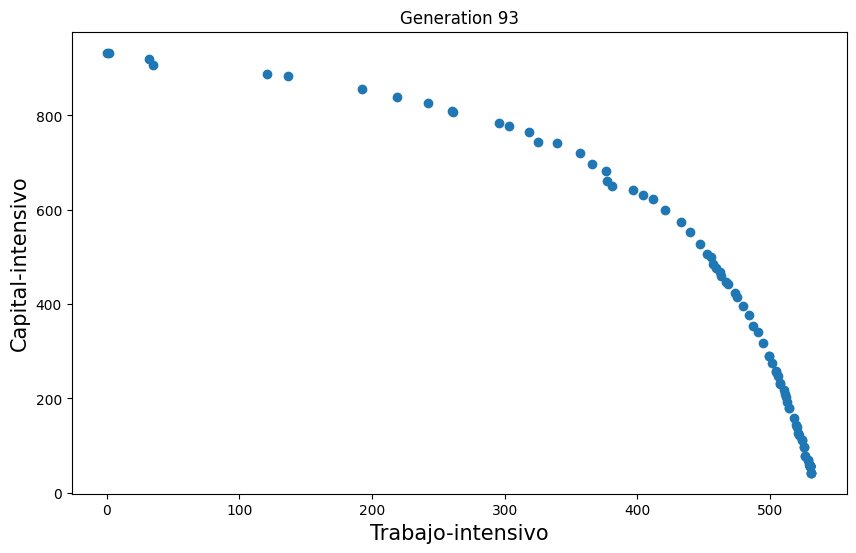

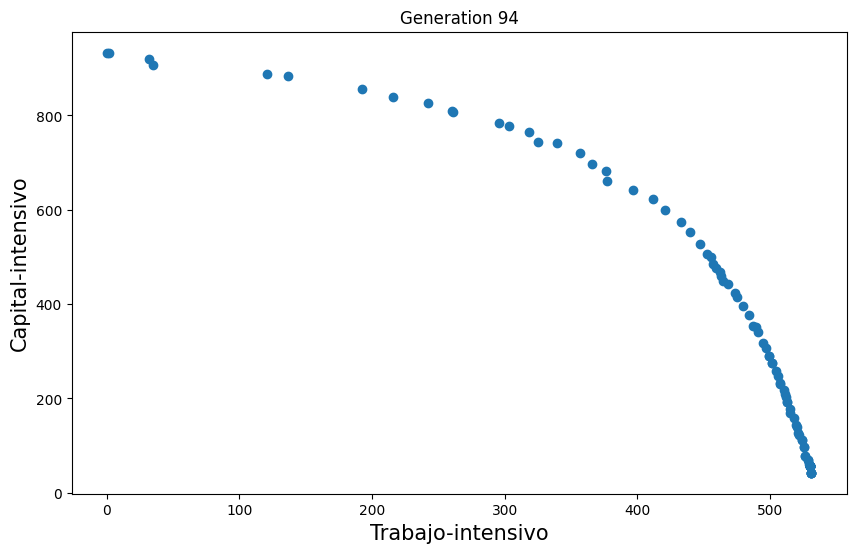

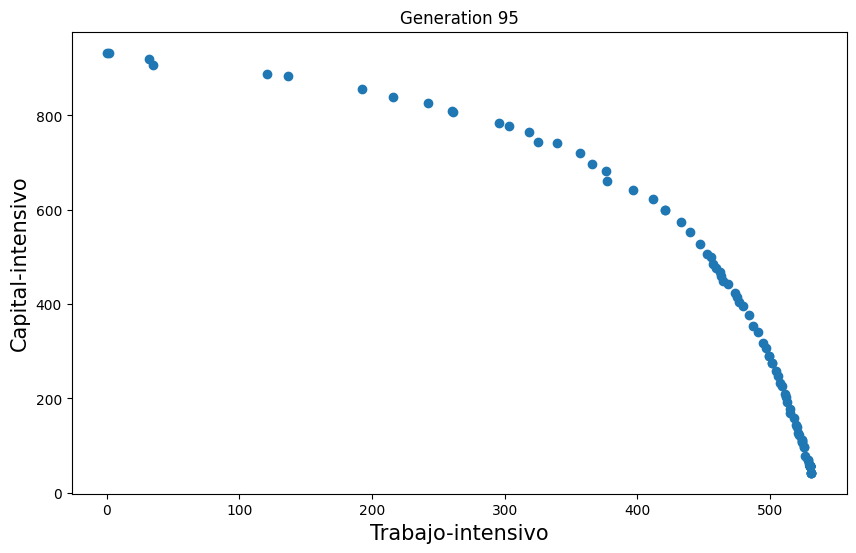

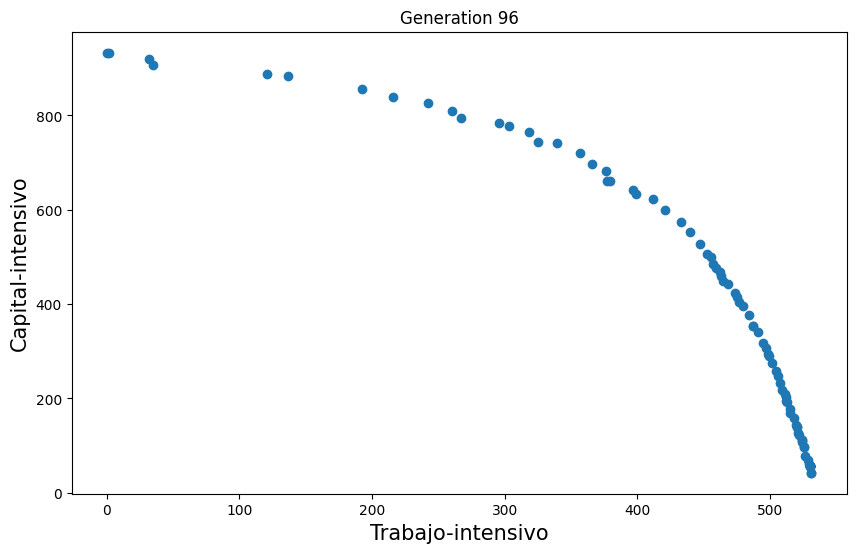

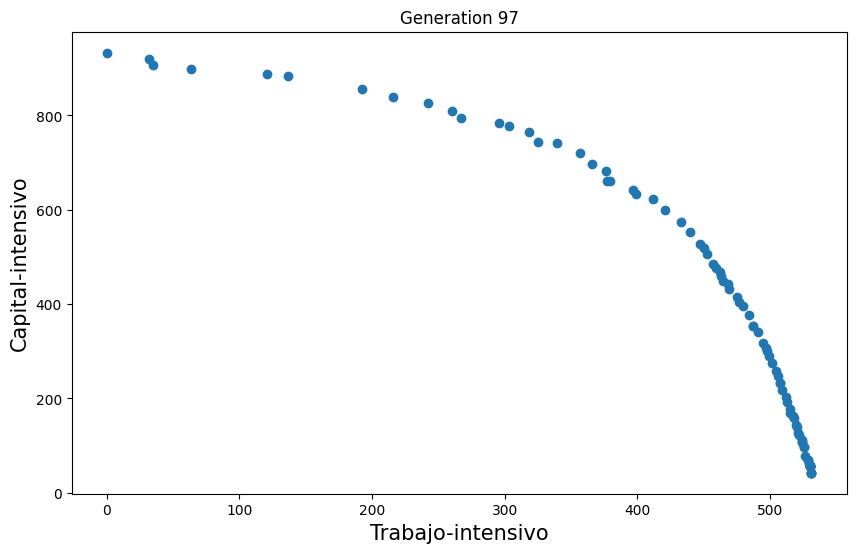

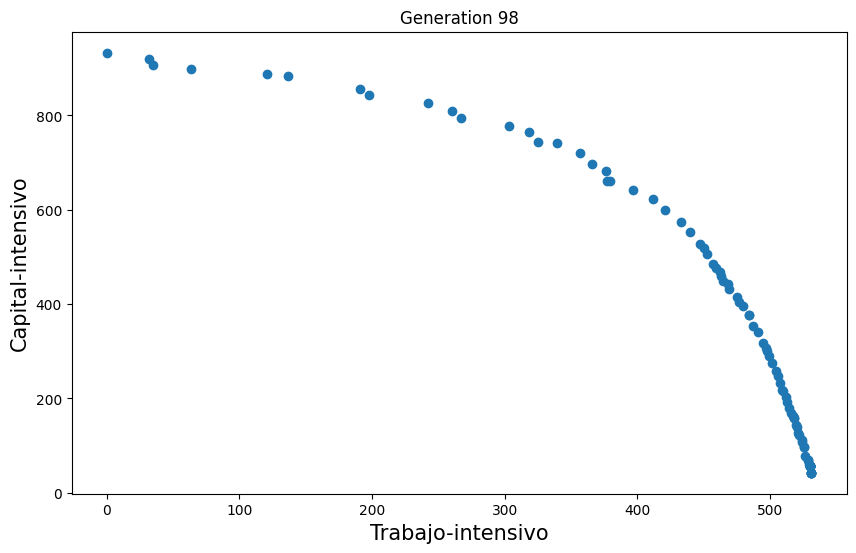

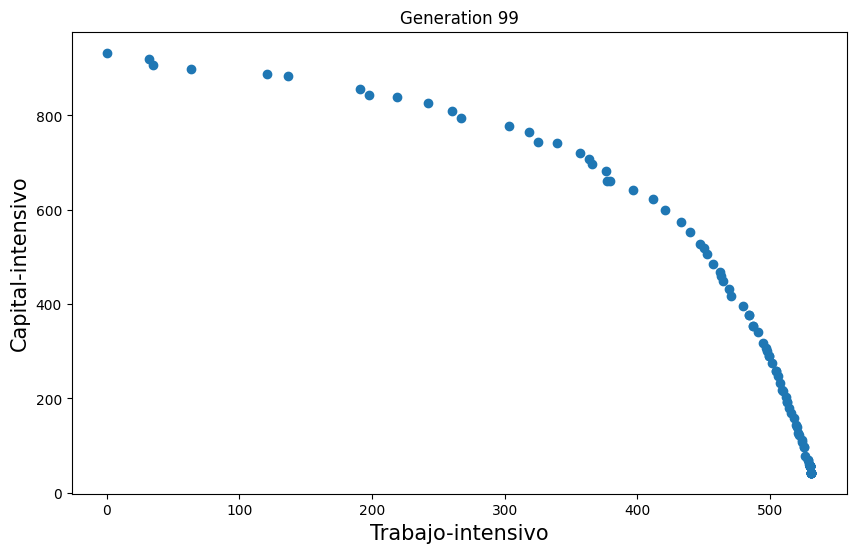

In [ ]:
# Visualize the progress over generations
for gen, (f1_vals, f2_vals) in enumerate(progress):
    plt.figure(figsize=(10, 6))
    plt.scatter(f1_vals, f2_vals)
    plt.xlabel('Trabajo-intensivo', fontsize=15)
    plt.ylabel('Capital-intensivo', fontsize=15)
    plt.title(f'Generation {gen}')
    plt.show()